# **EDA**

## PRESENTACIÓN DEL DATAFRAME

In [210]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from IPython.display import display

In [145]:
df_drugs = pd.read_csv("../data/data_clean/drugs.csv", index_col=0)
df_drugs_no_na = pd.read_csv("../data/data_clean/drugs_no_na.csv", index_col=0)

In [7]:
df_drugs

,country,survey_year,prevalence_(%),substance,recall_period,age,sample_size,males_(%),females_(%),gender_gap
0,Austria,2020,22.7,Cannabis,Lifetime,Adults (15-64),4650.0,24.8,20.6,4.2
1,Austria,2020,27.2,Cannabis,Lifetime,Young adults (15-34),1712.0,26.8,27.6,-0.8
2,Austria,2020,6.3,Cannabis,Last year,Adults (15-64),4650.0,6.8,5.8,1.0
3,Austria,2020,11.1,Cannabis,Last year,Young adults (15-34),1712.0,10.7,11.4,-0.7
4,Austria,2020,3.6,Cannabis,Last month,Adults (15-64),4650.0,4.0,3.1,0.9
...,...,...,...,...,...,...,...,...,...,...
1038,Türkiye,2017,47.0,Tobacco,Lifetime,Young adults (15-34),NaN,61.9,33.2,28.7
1039,Türkiye,2017,33.4,Tobacco,Last year,Adults (15-64),NaN,45.0,22.5,22.5
1040,Türkiye,2017,33.2,Tobacco,Last year,Young adults (15-34),NaN,45.4,20.6,24.8
1041,Türkiye,2017,31.5,Tobacco,Last month,Adults (15-64),NaN,42.8,21.0,21.8


El conjunto de datos contiene 1043 observaciones de consumo de estupefacientes en Europa y Turquía, recopiladas en diversos años y para distintos grupos de edad. Cada fila representa una medición específica del consumo de una sustancia en un país, un período de referencia y un grupo etario determinado.

**Columnas principales:**

* country: País donde se realizó la encuesta (países europeos y Turquía)

* survey_year: Año en el cual se realizó la encuesta (rango 2008-2022).

* prevalence_(%): Porcentaje de la población que ha consumido el estupefaciente 

* substance: Tipo de sustancia evaluada, como Cannabis, Tobacco, Cocaine, entre otros.

* recall_period: Periodo de referencia del consumo: Lifetime (consumo alguna vez), Last year (último año), Last month (último mes).

* age: Grupo de edad de la población encuestada - Adults (15-64) o Young adults (15-34).

* sample_size: Tamaño de la muestra utilizada en la encuesta

* males_(%) y females_(%): Porcentaje de hombres y mujeres que reportan haber consumido la sustancia.

* gender_gap: Diferencia entre hombres y mujeres (males_(%) - females_(%))


# **ANÁLISIS: CARDINALIDAD**

## 1. CARDINALIDAD: ANÁLISIS UNIVARIANTE

In [146]:
# Función que calcula la cardinalidad y el tipo de variable
def cardinalidad(df_in, umbral_categoria = 10, umbral_continua = 30):

    resultado = []
    for col in df_in.columns:
        card = df_in[col].nunique()
        porc_card = df_in[col].nunique()/len(df_in) * 100
        tipo = df_in[col].dtypes
        if card == 2:
            clasif = "Binaria"
        elif card < umbral_categoria:
            clasif = "Categórica"
        elif card >= umbral_categoria:
            if porc_card >= umbral_continua:
                clasif = "Numérica Continua"
            else:
                clasif = "Numérica Discreta"

        # Añadimos los resultados a la lista
        resultado.append({
            "columna": col,
            "tipo": tipo,
            "cardinalidad": card,
            "porcentaje_card": porc_card,
            "clasificacion": clasif
        })
    
    # Convertimos la lista de dicts en dataframe
    df_resul = pd.DataFrame(resultado)
        
    return df_resul

# 3. Función que representa las frecuencias absolutas o relativas en gráficos
def pinta_distribucion_categoricas(df, columnas_categoricas, relativa=False, mostrar_valores=False):
    num_columnas = len(columnas_categoricas)
    num_filas = (num_columnas // 2) + (num_columnas % 2)

    fig, axes = plt.subplots(num_filas, 2, figsize=(15, 5 * num_filas))
    axes = axes.flatten() 

    for i, col in enumerate(columnas_categoricas):
        ax = axes[i]
        if relativa:
            total = df[col].value_counts().sum()
            serie = df[col].value_counts().apply(lambda x: x / total)
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis', hue = serie.index, legend = False)
            ax.set_ylabel('Frecuencia Relativa')
        else:
            serie = df[col].value_counts()
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis', hue = serie.index, legend = False)
            ax.set_ylabel('Frecuencia')

        ax.set_title(f'Distribución de {col}')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45)

        if mostrar_valores:
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    for j in range(i + 1, num_filas * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def columnas_numericas(df):
    num_col = df.describe().columns.to_list()
    return num_col

# Función para representar boxplots de columnas numéricas
def plot_multiple_boxplots(df, columns, dim_matriz_visual = 2):
    num_cols = len(columns)
    num_rows = num_cols // dim_matriz_visual + num_cols % dim_matriz_visual
    fig, axes = plt.subplots(num_rows, dim_matriz_visual, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.boxplot(data=df, x=column, ax=axes[i])
            axes[i].set_title(column)

    # Ocultar ejes vacíos
    for j in range(i+1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_histo_dens(df, columns, bins=None):
    num_cols = len(columns)
    num_rows = num_cols // 2 + num_cols % 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            if bins:
                sns.histplot(df[column], kde=True, ax=axes[i], bins=bins)
            else:
                sns.histplot(df[column], kde=True, ax=axes[i])
            axes[i].set_title(f'Histograma y KDE de {column}')

    # Ocultar ejes vacíos
    for j in range(i + 1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Función que representa el histograma y el boxplot de varias variables
def plot_combined_graphs(df, columns, whisker_width=1.5):
    num_cols = len(columns)
    if num_cols:
        
        fig, axes = plt.subplots(num_cols, 2, figsize=(12, 5 * num_cols))
        print(axes.shape)

        for i, column in enumerate(columns):
            if df[column].dtype in ['int64', 'float64']:
                # Histograma y KDE
                sns.histplot(df[column], kde=True, ax=axes[i,0] if num_cols > 1 else axes[0])
                if num_cols > 1:
                    axes[i,0].set_title(f'Histograma y KDE de {column}')
                else:
                    axes[0].set_title(f'Histograma y KDE de {column}')

                # Boxplot
                sns.boxplot(x=df[column], ax=axes[i,1] if num_cols > 1 else axes[1], whis=whisker_width)
                if num_cols > 1:
                    axes[i,1].set_title(f'Boxplot de {column}')
                else:
                    axes[1].set_title(f'Boxplot de {column}')

        plt.tight_layout()
        plt.show()

## 2. CARDINALIDAD: ANÁISIS BIVARIANTE

In [147]:
# Función análisis bivariante categóricas
def plot_categorical_relationship_fin(df, cat_col1, cat_col2, relative_freq=False, show_values=False, size_group = 5):

    # Prepara los datos
    count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')
    total_counts = df[cat_col1].value_counts()
    
    # Convierte a frecuencias relativas si se solicita
    if relative_freq:
        count_data['count'] = count_data.apply(lambda x: x['count'] / total_counts[x[cat_col1]], axis=1)

    # Si hay más de size_group categorías en cat_col1, las divide en grupos de size_group
    unique_categories = df[cat_col1].unique()
    if len(unique_categories) > size_group:
        num_plots = int(np.ceil(len(unique_categories) / size_group))

        for i in range(num_plots):
            # Selecciona un subconjunto de categorías para cada gráfico
            categories_subset = unique_categories[i * size_group:(i + 1) * size_group]
            data_subset = count_data[count_data[cat_col1].isin(categories_subset)]

            # Crea el gráfico
            plt.figure(figsize=(5, 3))
            ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=data_subset, order=categories_subset)

            # Añade títulos y etiquetas
            plt.title(f'Relación entre {cat_col1} y {cat_col2} - Grupo {i + 1}')
            plt.xlabel(cat_col1)
            plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
            plt.xticks(rotation=45)

            # Mostrar valores en el gráfico
            if show_values:
                for p in ax.patches:
                    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                                textcoords='offset points')

            # Muestra el gráfico
            plt.show()
    else:
        # Crea el gráfico para menos de size_group categorías
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=count_data)

        # Añade títulos y etiquetas
        plt.title(f'Relación entre {cat_col1} y {cat_col2}')
        plt.xlabel(cat_col1)
        plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
        plt.xticks(rotation=45)

        # Mostrar valores en el gráfico
        if show_values:
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                            textcoords='offset points')

        # Muestra el gráfico
        plt.show()

def grafico_dispersion_con_correlacion(df, columna_x, columna_y, tamano_puntos=50, mostrar_correlacion=False):
    """
    Crea un diagrama de dispersión entre dos columnas y opcionalmente muestra la correlación.

    Args:
    df (pandas.DataFrame): DataFrame que contiene los datos.
    columna_x (str): Nombre de la columna para el eje X.
    columna_y (str): Nombre de la columna para el eje Y.
    tamano_puntos (int, opcional): Tamaño de los puntos en el gráfico. Por defecto es 50.
    mostrar_correlacion (bool, opcional): Si es True, muestra la correlación en el gráfico. Por defecto es False.
    """

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=columna_x, y=columna_y, s=tamano_puntos)

    if mostrar_correlacion:
        correlacion = df[[columna_x, columna_y]].corr().iloc[0, 1]
        plt.title(f'Diagrama de Dispersión con Correlación: {correlacion:.2f}')
    else:
        plt.title('Diagrama de Dispersión')

    plt.xlabel(columna_x)
    plt.ylabel(columna_y)
    plt.grid(True)
    plt.show()

# **ANÁLISIS BASE**

A continuación, se muestran una serie de análisis base para todas las hipótesis del presente estudio.

In [8]:
df_drugs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1043 entries, 0 to 1042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         1043 non-null   object 
 1   survey_year     1043 non-null   int64  
 2   prevalence_(%)  1043 non-null   float64
 3   substance       1043 non-null   object 
 4   recall_period   1043 non-null   object 
 5   age             1043 non-null   object 
 6   sample_size     950 non-null    float64
 7   males_(%)       1017 non-null   float64
 8   females_(%)     1001 non-null   float64
 9   gender_gap      1001 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 89.6+ KB


El presente análisis muestra que nuestro dataset contiene 1043 filas, hehcho que mostraría un tamaño moderado para análisis estadísticos.

Asimismo, hay 10 columnas, de las cuales 4 son **categóricas** (country, substance, recall_period, age) y 6 **numéricas** (survey_year, prevalence_(%), sample_size, males_(%), females_(%), gender_gap)

Además, se observan valores faltantes (NaN) en:

* sample_size (950 de 1043) → faltaría información en algunas encuestas sobre el número de personas encuestadas.

* males_(%) (1017 de 1043) y females_(%) (1001 de 1043) → algunas encuestas no informan el porcentaje por sexo.

* gender_gap (1001 de 1043) → ya que se calcula como diferencia de los anteriores, los valores faltantes se transmiten.


In [9]:
df_drugs.describe()

,survey_year,prevalence_(%),sample_size,males_(%),females_(%),gender_gap
count,1043.000000,1043.000000,950.000000,1017.000000,1001.000000,1001.000000
mean,2018.776606,17.558581,4260.586316,19.904621,15.596803,4.624276
std,2.174479,26.759251,4568.853108,28.697494,25.437743,6.281016
min,2008.000000,0.000000,442.000000,0.000000,0.000000,-4.000000
25%,2018.000000,0.600000,1572.000000,0.800000,0.300000,0.400000
50%,2019.000000,2.800000,2957.000000,3.900000,1.800000,1.900000
75%,2020.000000,26.150000,4994.000000,32.000000,21.300000,6.600000
max,2022.000000,98.900000,26344.000000,99.600000,98.200000,38.400000


El estudio de .describe() proporciona información descriptiva de diversas columnas:
**survey_year**

* Media: 2018.78, desviación estándar: 2.17.

Los datos son recientes, principalmente del periodo 2018–2022, con algunos registros desde 2008.

Esto indica que el análisis se centra en consumos actuales o recientes, lo que es coherente con un EDA de tendencias modernas.

**prevalence_(%)**

* Media: 17.56%, desviación estándar: 26.76%, mínimo 0%, máximo 98.9%.

Hay una variabilidad alta en la prevalencia de consumo. La mayoría de los valores son bajos, pero hay encuestas con prevalencia muy alta, posiblemente para sustancias como alcohol o cannabis en grupos específicos.

**sample_size**

* Media: 4260, rango: 442–26,344.

La amplitud muestra que algunas encuestas son muy grandes y otras más pequeñas.

**males_(%) y females_(%)**

* Hombres: media 19.90%, std 28.69%

* Mujeres: media 15.60%, std 25.43%

En promedio, los hombres consumen más que las mujeres aunque hay una desviación estándard elevada. Esto podría mostrar dispersión e indicar que en algunos países tendrían consumos similares. 

**gender_gap**

* Media: 4.62%, mínimo -4%, máximo 38.4%

En promedio, hay mayor consumo en hombres, pero hay casos donde las mujeres superan a los hombres (valores negativos)

In [103]:
df_drugs.columns.tolist()

['country',
 'survey_year',
 'prevalence_(%)',
 'substance',
 'recall_period',
 'age',
 'sample_size',
 'males_(%)',
 'females_(%)',
 'gender_gap']

La lista de nuestras columnas confirma que tenemos todas las variables necesarias para analizar las hipótesis. Asimismo, es útil para planificar análisis univariantes (por ejemplo, solo prevalence_(%)), bivariantes (prevalence_(%) vs age o gender_gap) y multivariantes (prevalence_(%) vs gender_gap y country).

# **HIPÓTESIS 1**

>*H1. Los hombres consumen más estupefacientes que las mujeres en todos los grupos de edad*

## 1.1 ANÁLISIS UNIVARIANTE - HECHO

Antes de nada, volvemos a mostrar el dataframe:

In [29]:
df_drugs

,country,survey_year,prevalence_(%),substance,recall_period,age,sample_size,males_(%),females_(%),gender_gap
0,Austria,2020,22.7,Cannabis,Lifetime,Adults (15-64),4650.0,24.8,20.6,4.2
1,Austria,2020,27.2,Cannabis,Lifetime,Young adults (15-34),1712.0,26.8,27.6,-0.8
2,Austria,2020,6.3,Cannabis,Last year,Adults (15-64),4650.0,6.8,5.8,1.0
3,Austria,2020,11.1,Cannabis,Last year,Young adults (15-34),1712.0,10.7,11.4,-0.7
4,Austria,2020,3.6,Cannabis,Last month,Adults (15-64),4650.0,4.0,3.1,0.9
...,...,...,...,...,...,...,...,...,...,...
1038,Türkiye,2017,47.0,Tobacco,Lifetime,Young adults (15-34),NaN,61.9,33.2,28.7
1039,Türkiye,2017,33.4,Tobacco,Last year,Adults (15-64),NaN,45.0,22.5,22.5
1040,Türkiye,2017,33.2,Tobacco,Last year,Young adults (15-34),NaN,45.4,20.6,24.8
1041,Türkiye,2017,31.5,Tobacco,Last month,Adults (15-64),NaN,42.8,21.0,21.8


Para explorar la primera hipótesis, que plantea que los hombres consumen más drogas que las mujeres, se muestran datos descriptivos de las principales variables de la hipótesis: age, males_(%), females_(%), substance y prevalence_(%).

In [10]:
df_drugs["age"].describe()

count               1043
unique                 2
top       Adults (15-64)
freq                 528
Name: age, dtype: object

In [11]:
df_drugs["males_(%)"].describe()

count    1017.000000
mean       19.904621
std        28.697494
min         0.000000
25%         0.800000
50%         3.900000
75%        32.000000
max        99.600000
Name: males_(%), dtype: float64

In [12]:
df_drugs["females_(%)"].describe()

count    1001.000000
mean       15.596803
std        25.437743
min         0.000000
25%         0.300000
50%         1.800000
75%        21.300000
max        98.200000
Name: females_(%), dtype: float64

In [13]:
df_drugs["prevalence_(%)"].describe()

count    1043.000000
mean       17.558581
std        26.759251
min         0.000000
25%         0.600000
50%         2.800000
75%        26.150000
max        98.900000
Name: prevalence_(%), dtype: float64

In [14]:
df_drugs["substance"].describe()

count         1043
unique           7
top       Cannabis
freq           171
Name: substance, dtype: object

La variable **age** dejaría ver que la muestra se divide en dos grupos: Adults (15-64) y Young adults (15-34). La categoría más frecuente es la de adultos (528 observaciones), hecho que indicaría que la mayor parte de los datos corresponde a población adulta a pesar de que también se dispone de una representación significativa de jóvenes. 

En cuanto a los porcentajes de consumo por **sexo**, los hombres presentan un promedio de consumo de 19.90% y una mediana de 3.90%, frente un promedio de 15.60% y mediana de 1.80% de las mujeres. Asimismo, se presenta una desviación estándard elevada (28.7% vs. 25.4% respectivamente) que muestra una gran variabilidad. La mediana baja sugeriría que, en la mayoría de los casos, el consumo es relativamente reducido, pero algunos casos puntuales elevan considerablemente la media, indicando que existen grupos con prevalencias muy altas.

Finalmente, la variable **prevalence_(%)** muestra un comportamiento similar: promedio de 17.56% y rango que va de 0% a 98.9%. Esto confirmaría la heterogeneidad del consumo. 

Respecto a las **sustancias**, la mayoría de los registros corresponden a Cannabis (171 observaciones), aunque el dataset incluye un total de 7 tipos de drogas, como alcohol o cocaina, lo que permite comparar patrones de consumo entre distintas sustancias.

En conjunto, este análisis univariante sugiere que, en promedio, los hombres presentan mayores niveles de consumo que las mujeres, aunque existen casos donde la diferencia es mínima o incluso se invierte, y que la distribución de consumo varía considerablemente según grupo etario y sustancia.

### 1.1.1 Análisis univariante de variables **categóricas**

Para realizar el análisis univariante, se ha examinado la distribución de las **variables categóricas** relevantes para la primera hipótesis: substance y age.

Se ha hecho también un **conteo de los valores absolutos**:

In [42]:
categorical_var = [  
    "substance",
    "age",
]

In [57]:
for catego in categorical_var:
	print(f"Para {catego}")
	print(df_drugs[catego].value_counts())
	print("\n"*2)

Para substance
substance
Cannabis        171
Cocaine         159
Ecstasy         159
Amphetamines    149
LSD             148
Alcohol         132
Tobacco         125
Name: count, dtype: int64



Para age
age
Adults (15-64)          528
Young adults (15-34)    515
Name: count, dtype: int64





**Sustancia (substance)**
El dataset incluye 7 tipos de sustancias: Cannabis, Cocaína, Éxtasis, Anfetaminas, LSD, Alcohol y Tabaco. La distribución absoluta de sus registros muestra que Cannabis es la sustancia más frecuente (171 observaciones), seguida de Cocaína y Éxtasis (159 observaciones cada una). Las otras sustancias se reparten de manera relativamente uniforme, con un mínimo de 125 registros para Tabaco.

**Grupos de edad (age)**
El conteo absoluto indica que la muestra está muy equilibrada entre los Adultos (15-64 años) con 528 observaciones y los Jóvenes adultos (15-34 años) con 515 observaciones. Esto permite analizar cómo varía el consumo entre los hombres y las mujeres en función de la edad, por ejemplo, sin que uno de los grupos predomine sobre el otro.


Asimismo, se han generado un gráfico de barras para estas variables categóricas:

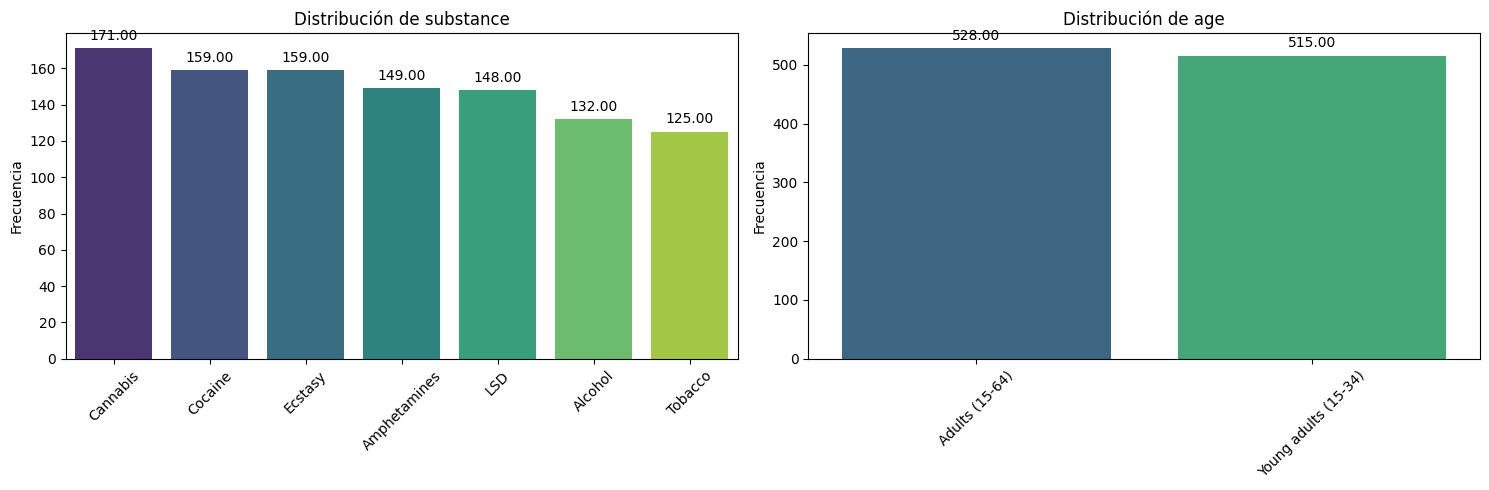

In [135]:
pinta_distribucion_categoricas(df_drugs, ["substance", "age"], relativa=False, mostrar_valores=True)

Este gráfico muestra la distribución de las sustancias, así como la prácticamente igualdad entre los grupos de edad. Con esta, se puede identificar dónde están concentrados la mayor parte de datos.
Ambas gráficas confirman lo que muestran los conteos absolutos anteriormanete mencionados:
* Substance: predomina el consumo de cannabis, seguida de cocaina, extasis, anfetaminas, LSD, alcohol y, finalmente, tabaco
* Age: se observa una representación equilibrada entre ambos grupos de edad

Para complementar el análisis en términos absolutos, se ha calculado la distribución **relativa** las variables substance y age, expresando los datos en porcentajes sobre el total de observaciones (1043).

In [105]:
for catego in categorical_var:
	print(f"Para {catego}")
	print(df_drugs[catego].value_counts()/len(df_drugs)*100)
	print("\n"*2)

Para substance
substance
Cannabis        16.395014
Cocaine         15.244487
Ecstasy         15.244487
Amphetamines    14.285714
LSD             14.189837
Alcohol         12.655801
Tobacco         11.984660
Name: count, dtype: float64



Para age
age
Adults (15-64)          50.623202
Young adults (15-34)    49.376798
Name: count, dtype: float64





**Substance**: Igual que en el análisis anterior, el cánnabis es la sustancia que más se observa (16.4%), seguida de la cocaina y extasis (15.24% cada una), las anfetaminas y el LSD (14.3% y 14.2% respectivamente), el alcohol (12.66%) y, finalmente, el tabado (12%)

**Age**: Se vuelve a apreciar que las dos franjas de edad (adulto y adultos jóvenes) están equilibrados, con aproximadamente los dos un 50% de representación

Para volver a observarlo de forma visual, se presenta, a continuación, una gráfica con los datos relativos aquí presentados:

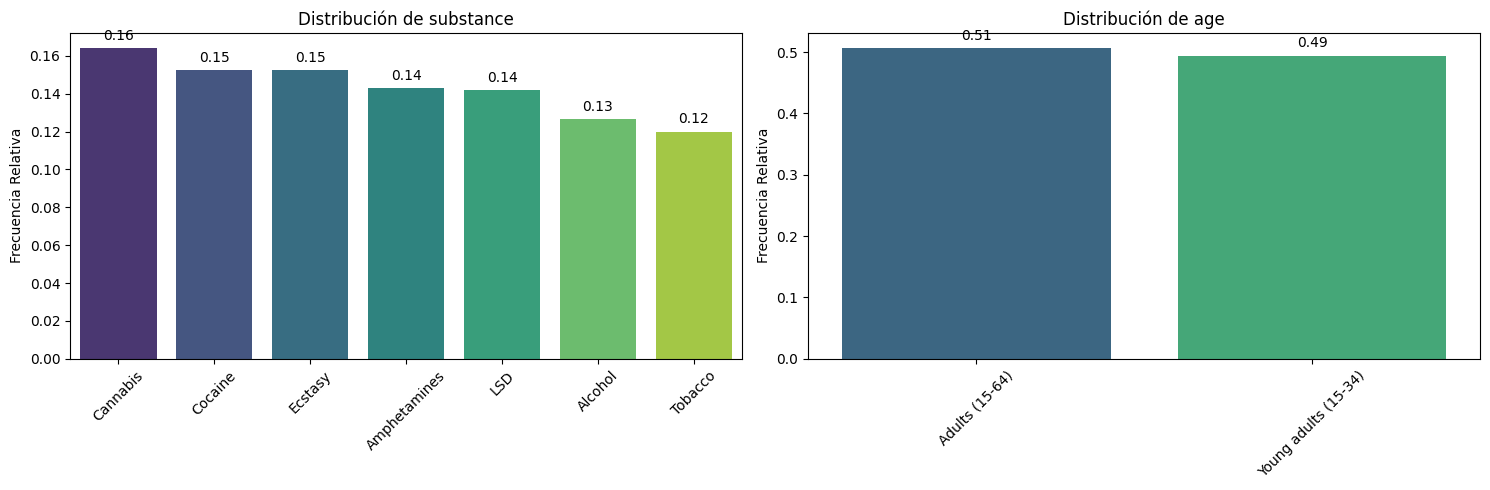

In [134]:
pinta_distribucion_categoricas(df_drugs, ["substance", "age"], relativa=True, mostrar_valores=True)

Tanto el análisis absoluto como el relativo indican que nuestro dataset tiene correcta diversidad de sustancias y equilibrio de edad, hecho que proporciona una base sólida para analizar la Hipótesis 1 respecto las diferencias de consumo entre hombres y mujeres.

### 1.1.2 Análisis univariante de variables **Numéricas**

Se ha llevado a cabo un análisis de las variables numéricas relevantes para la primera hipótesis, la cual tiene como objetivo estudiar si los hombres consumen más estupefacientes que las mujeres en todos los rangos de edad. Para ello, las **variables numéricas** que han sido examinadas son: prevalence_(%), males_(%) y females_(%).

In [30]:
num_cols = columnas_numericas(df_drugs)
numeric_cols = [
    "prevalence_(%)",
    "males_(%)",
    "females_(%)",
]   

Para el análisis univariante de las variables numéricas, tal y como se ha mencionado anteriormente, se seleccionaron únicamente prevalence_(%), males_(%) y females_(%) puesto que son las columnas vinculadas de forma directa con la Hipótesis 1. A pesar de que nuestro dataset dispone de otras columnas que también son numéricas, nuestra selección nos permite centrarnos en las métricas que son relevantes para nuestro estudio.

Asimismo y, de manera complementaria, se han identificado las columnas numéricas de nuestro dataset con el objetivo de disponer de una visión general del comportamiento de las variables.

Por su parte, se han generado histogramas con curvas de densidad, así como boxplots para las variables **prevalence_(%), males_(%) y females_(%)** para analizar visualmente patrones de consumo y facilitar la interpretación de la Hipótesis 1.

*Histograma*

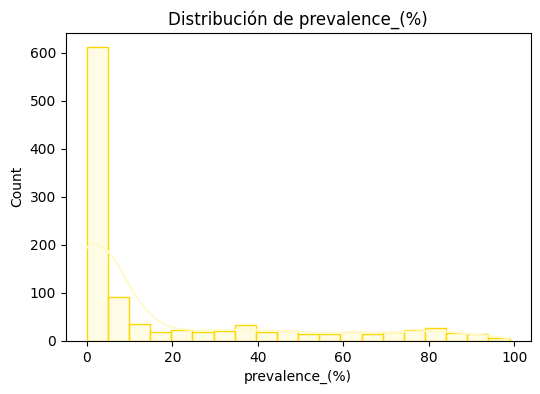

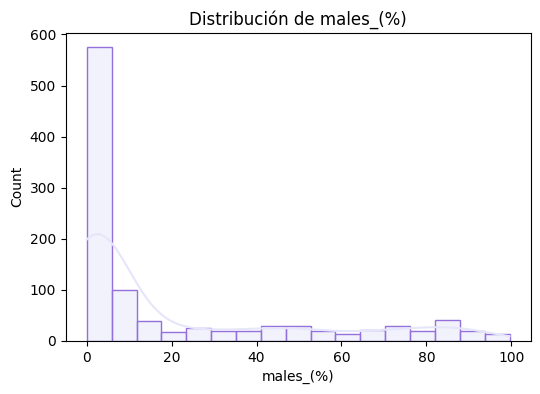

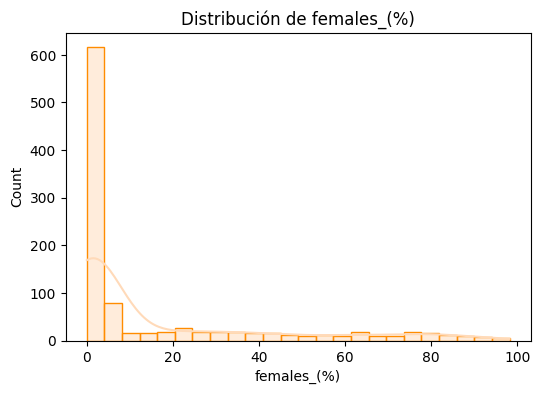

In [133]:
numeric_cols = ["prevalence_(%)", "males_(%)", "females_(%)"]
colors = ["#FFFACD", "#E6E6FA", "#FFDAB9"]
border_colors = ["#FFD700", "#9370DB", "#FF8C00"]

for i, col in enumerate(numeric_cols):
    plt.figure(figsize=(6,4))
    sns.histplot(
        df_drugs[col].dropna(),
        kde=True,
        color=colors[i],
        edgecolor=border_colors[i]
    )
    plt.title(f"Distribución de {col}")
    plt.show()

*Bloxplot*

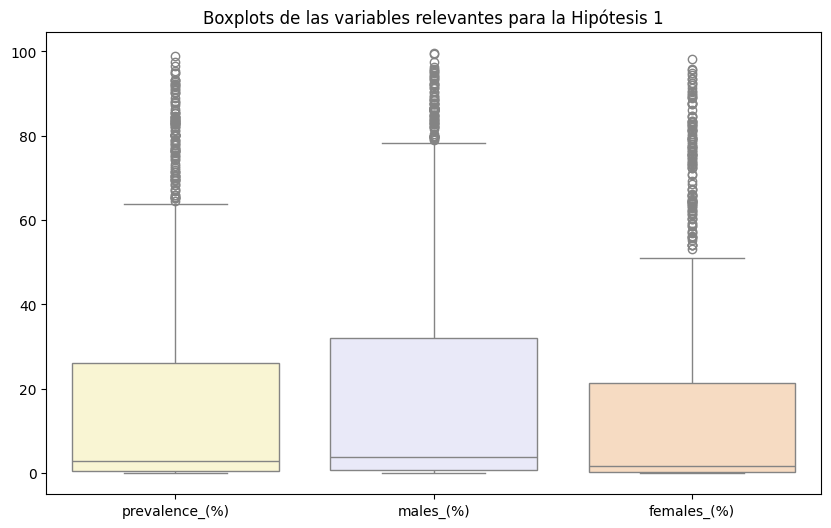

In [127]:
numeric_cols2 = ["prevalence_(%)", "males_(%)", "females_(%)"]
colors = ["#FFFACD", "#E6E6FA", "#FFDAB9"]

plt.figure(figsize=(10,6))
sns.boxplot(data=df_drugs[numeric_cols2], palette = colors)
plt.title("Boxplots de las variables relevantes para la Hipótesis 1")
plt.show()

**Prevalencia (prevalence_(%)**:

* El *histograma* expone que la mayoría de los registros se concentra en valores bajos (cercanos a 0–5%) a pesar de que hay casos extremos cercanos a 100%. Por su parte, la curva de densidad indicaría una distribución asimétrica con una larga cola hacia valores altos.

* Asimismo, los *boxplots* confirman la presencia de outliers (prevalencias muy elevadas en ciertas sustancias, grupos o países.

En conclusión, aunque la media (17.6%) es relativamente alta, la mediana (2.8%) mostraría que la mayoría de los registros reportan consumos bajos. Ello indicaría que existen determinados casos extremos que elevarían la media.

**Consumo masculino (males_(%))**:

* El *histograma* muestra una concentración de valores bajos, con ciertos casos de consumo muy alto. Su media (19.9%) es notablemente superior a la mediana (3.9%), hecho que indicaría que la mayoría de hombres tiene consumos bajos aunque existen valores extremos que elevarían el promedio 

El *boxplot* refleja claramente los outliers y la gran dispersión, confirmando diferencias significativas entre países, sustancias y grupos etarios.

**Consumo femenino (females_(%))**:

* La distribución es similar a la de los hombres: la mayoría de valores son bajos pero existen registros con consumos elevados. Por su parte, tanto la media (15.6%) como la mediana (1.8%) son menores que las de los hombres, sugiriendo que, en términos generales los hombres consumen más que las mujeres. No obstante, cabe tener en consideración que existen casos en los cuales la diferencia es pequeña o se invierte.

* Los *boxplots* muestran también outliers en este caso, indicando variabilidad significativa en ciertos contextos.

Finalmene y, para completar el análisis univariante, se ha calculado el **rango** de cada variable numérica, esto es, la diferencia entre el valor máximo y mínimo. Con ello podemos evaluar la amplitud de los datos, así como la posible presencia de valores extremos que influirían en estadísticos de tendencia central. 

In [122]:
df_drugs.describe().loc["max"] - df_drugs.describe().loc["min"]

survey_year          14.0
prevalence_(%)       98.9
sample_size       25902.0
males_(%)            99.6
females_(%)          98.2
gender_gap           42.4
dtype: float64

Los resultados del análisis del rango muestran la siguiente información:

* survey_year: tiene un rango de 14 años, reflejando que los datos abarcarían, princialmente, de 2008 a 2022.

* prevalence_(%): presenta un rango de 98.9%, mostrando que la prevalencia de consumo varíaría desde 0% hasta casi 100% en determinados registros.

* sample_size: dispone de un rango de 25,902 encuestados, indicando una variabilidad alta en el tamaño de las muestras.

* males_(%) y females_(%): tienen rangos de 99.6% y 98.2% respectivamente, hecho que confirma la existencia de valores extremos en el consumo reportado por sexo

* gender_gap: presenta un rango de 42.4%, mostrando diferencias significativas entre hombres y mujeres en algunos casos.

De forma complementaria, se ha realizado una representación gráfica mediante histogramas:

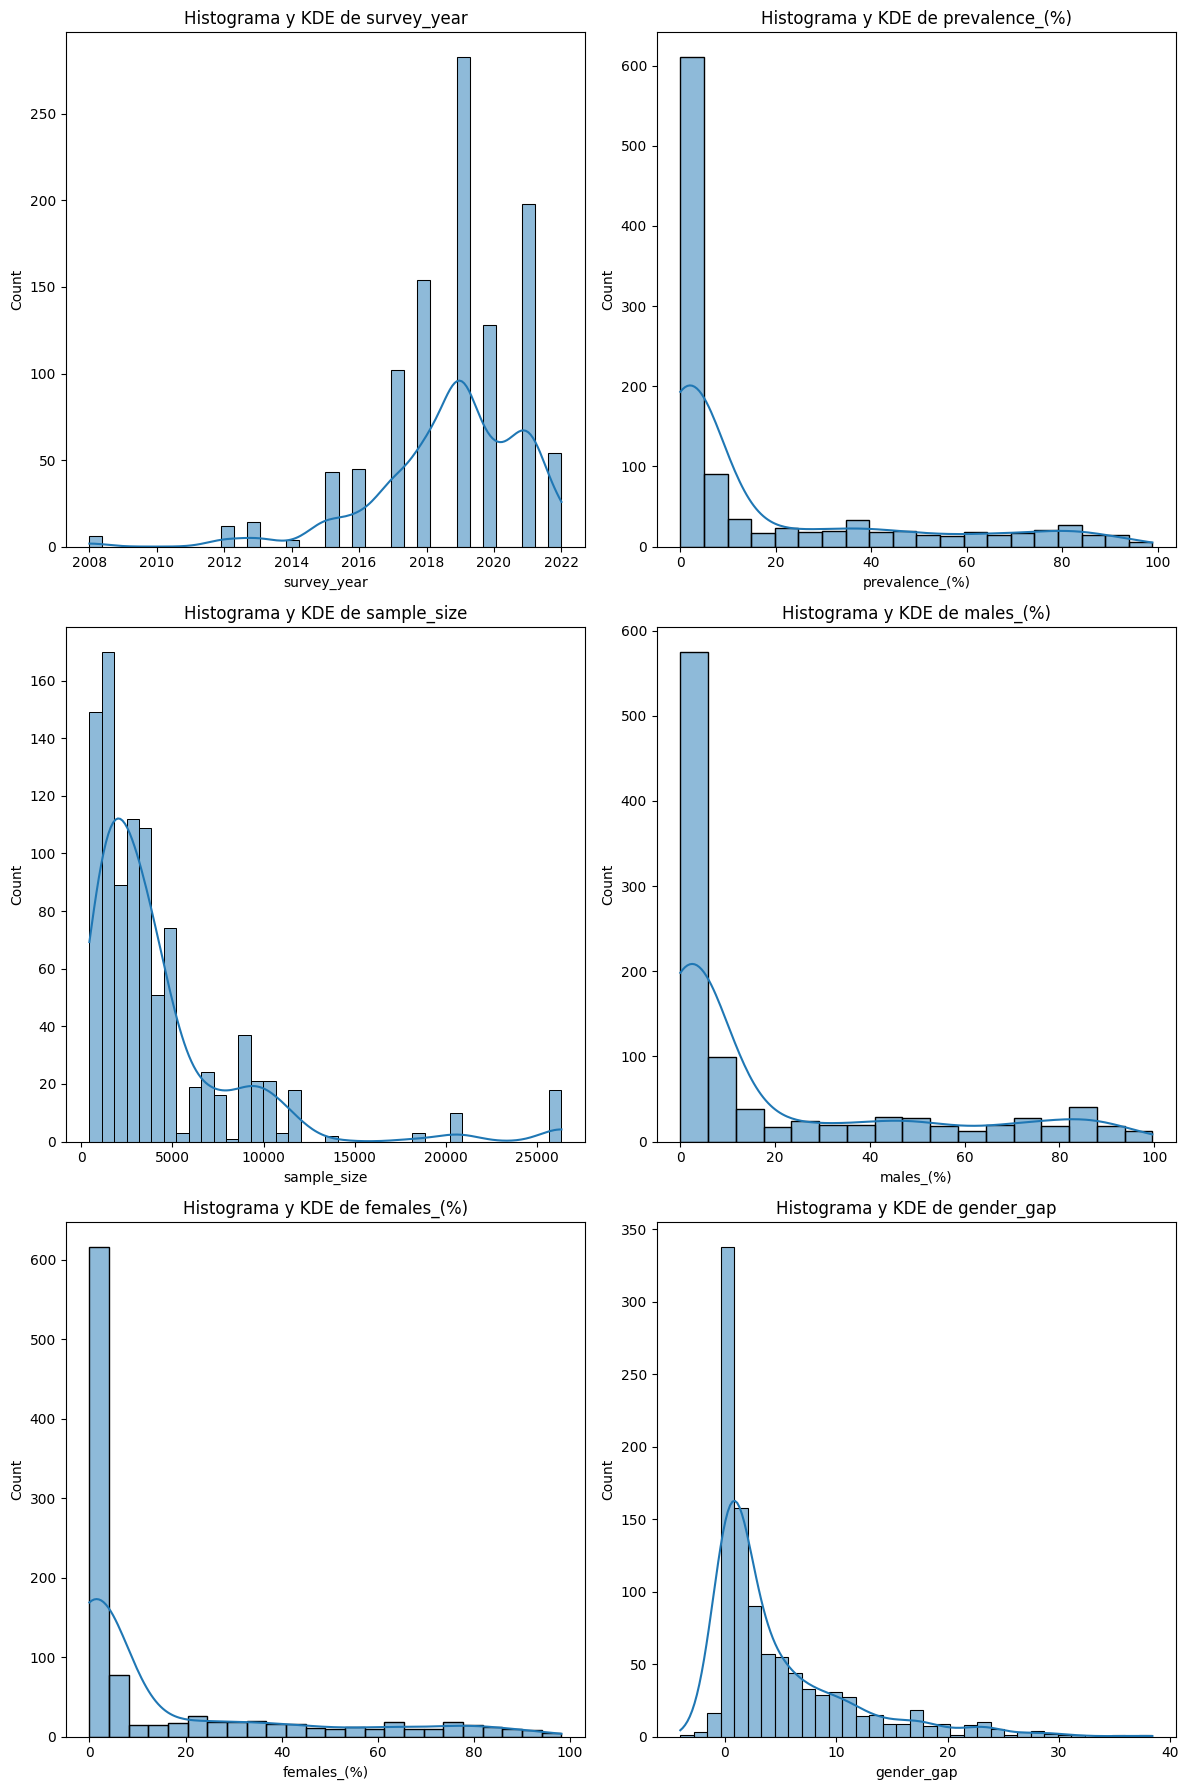

In [123]:
plot_histo_dens(df_drugs, columns=num_cols)

Estos histogramas muestran la distribución de cada una de las variables numéricas y nos permite identificar concentraciones de valores bajos, así como colas largas con registros extremos.

En las variables relevantes para la presente hipótesis, esto es, prevalence_(%), males_(%), females_(%), los valores se concentran, principalmente, en niveles bajos. No obstante, se aprecia la existencia de regsitros extremos que elevarían tanto la media como el rango.

Esta representación gráfica refuerza la interpretación de los boxplots y histogramas anteriores, mostrando de manera visual la heterogeneidad y dispersión de los datos.

En conclusión estos análisis confirman que las variables de consumo presentan gran variabilidad y outliers. 

Asimismo, los hombres tienen consumos más elevados en promedio que las mujeres, a pesar de que la dispersión es elevada, hecho que justificaría continuar con análisis bivariantes para explorar diferencias por sexo y grupos de edad.

## 1.2 ANÁLISIS BIVARIANTE - HECHO

Para profundizar en la Hipótesis 1, se ha realizado un análisis bivariante, el cual nos ha permitido explorar relaciones entre 2 variables a la vez, así como apreciar cómo varía el consumo de estupefacientes en función del sexo, la edad y la sustancia. El análisis se ha organizado en tres secciones, según el tipo de variables involucradas:
* Categórica - categórica
* Numérica - numérica
* Categórica - numérica

### ANÁLISIS CATEGÓRICA - CATEGÓRICA

En este apartado se analiza la relación existente entre las variables categóricas: 

* age (grupo de edad)
* substance (tipo de sustancia)

El objetivo ha sido identificar posibles patrones en la distribución del consumo.
De esta forma, hemos podido evaluar si existen grupos de edad que estén más representados dentro del consumo de ciertas sustancias y hemos podido detectar si existen concentraciones de observaciones en ciertas combinaciones de categorías.

In [148]:
df_drugs.groupby("age", as_index = False)["substance"].value_counts(normalize = True)

,age,substance,proportion
0,Adults (15-64),Cannabis,0.164773
1,Adults (15-64),Cocaine,0.151515
2,Adults (15-64),Ecstasy,0.151515
3,Adults (15-64),Amphetamines,0.142045
4,Adults (15-64),LSD,0.140152
5,Adults (15-64),Alcohol,0.128788
6,Adults (15-64),Tobacco,0.121212
7,Young adults (15-34),Cannabis,0.163107
8,Young adults (15-34),Cocaine,0.153398
9,Young adults (15-34),Ecstasy,0.153398


Los resultados de este análisis muestran que la distribución de sustancias es prácticamente homogénea en los dos grupos de edad: tanto en adultos (15–64) como en jóvenes adultos (15–34), el **cannabis** es la sustancia más frecuente, seguido por la cocaína y el éxtasis, mientras que el alcohol y el tabaco presentan proporciones ligeramente inferiores. Puede apreciarse que las diferencias entre grupos de edad son mínimas y no se  evidencian patrones diferenciados relevantes.

Este comportamiento podría sugerir que el grupo de edad no condiciona significativamente el tipo de sustancia registrada en el dataset, al menos desde un punto de vista descriptivo. Esto es, no se observa que ciertas sustancias estén asociadas de forma clara a un grupo de edad específico, sino que el consumo aparece repartido de manera similar entre adultos y jóvenes adultos.

In [149]:
df_drugs.groupby("substance")["age"].describe()

,count,unique,top,freq
substance,,,,
Alcohol,132,2,Adults (15-64),68
Amphetamines,149,2,Adults (15-64),75
Cannabis,171,2,Adults (15-64),87
Cocaine,159,2,Adults (15-64),80
Ecstasy,159,2,Adults (15-64),80
LSD,148,2,Adults (15-64),74
Tobacco,125,2,Adults (15-64),64


Desde la perspectiva inversa, esto es, analizando la composición por edad dentro de cada sustancia, se aprecia que todas las sustancias incluyen ambos grupos de edad, con una presencia ligeramente mayor de adultos (15–64). No obstante, esta diferencia es reducida y consistente entre sustancias, hecho que indicaría que no existe una sobrerrepresentación destacable de ningún grupo de edad en ninguna sustancia concreta.

Para complementar el análisis, se ha realizado una gráfica para poder comprenderlo de forma visual:

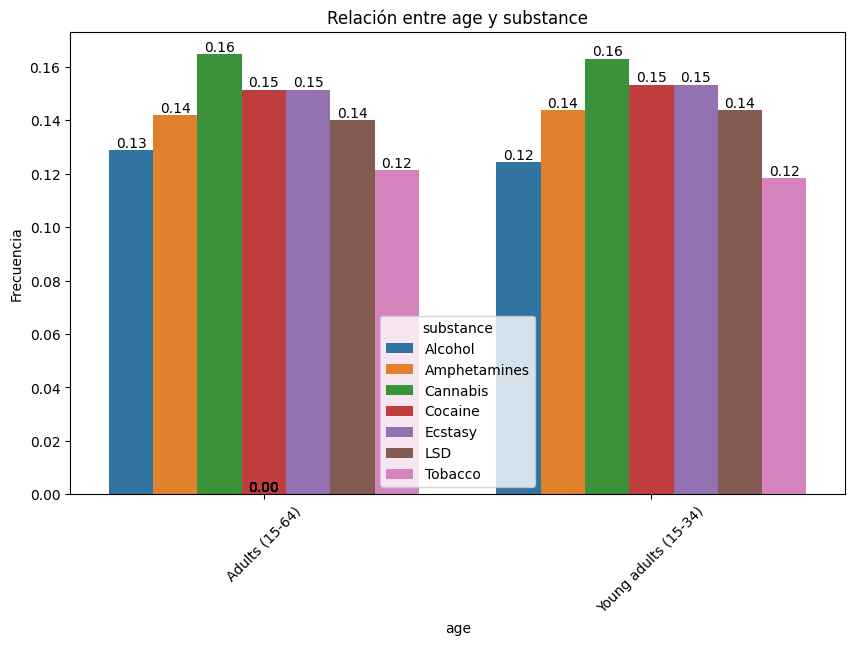

In [152]:
plot_categorical_relationship_fin(df_drugs, "age", "substance", relative_freq=True, show_values=True)

La visualización gráfica de las frecuencias relativas refuerza las conclusiones anteriores: barras de altura son similares para ambos grupos de edad en todas las sustancias. Así, no se han identificado concentraciones extremas que sugieran un vínculo destacable fuerte entre edad y tipo de sustancia.

En conclusión, el tipo de sustancia consumida no varía sustancialmente según el grupo de edad, mostrándose una estructura equilibrada entre edad y sustancia

Paralelamente y, con el objetivo de evaluar si existe una relación estadísticamente significativa entre el grupo de edad (age) y el tipo de sustancia (substance), se ha construido una **tabla de contingencia** y se ha aplicado el **test de Chi-cuadrado**.

In [150]:
tabla_contingencia = pd.crosstab(df_drugs['substance'], df_drugs['age'])
tabla_contingencia

age,Adults (15-64),Young adults (15-34)
substance,,
Alcohol,68,64
Amphetamines,75,74
Cannabis,87,84
Cocaine,80,79
Ecstasy,80,79
LSD,74,74
Tobacco,64,61


In [151]:
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)


print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("Tabla de Frecuencias Esperadas:\n", expected)


Valor Chi-Cuadrado: 0.10311714713419907
P-Value: 0.9999780224419544
Grados de Libertad: 6
Tabla de Frecuencias Esperadas:
 [[66.82262704 65.17737296]
 [75.42857143 73.57142857]
 [86.56567593 84.43432407]
 [80.49089166 78.50910834]
 [80.49089166 78.50910834]
 [74.92233941 73.07766059]
 [63.27900288 61.72099712]]


La tabla de contingencia expone que, para todas las sustancias analizadas, las frecuencias observadas en adultos (15–64) y jóvenes adultos (15–34) son similares. Esta homogeneidad ya se intuía en el análisis descriptivo previos, pero el test estadístico permite confirmarlo.

Por su parte, el resultado del test Chi-cuadrado muestra:

* Un valor del estadístico χ² = 0.103 (extremadamente bajo).
* Un p-valor = 0.9999, superior al nivel de significación habitual, esto es, α = 0.05.
* 6 grados de libertad.

La comparación entre las frecuencias observadas y esperadas bajo el supuesto de independencia reforzaría que los valores esperados son prácticamente idénticos a los observados, explicando, así, el valor tan reducido del Chi-cuadrado.


Por lo tanto y, dado este **p-valor** tan elevado, no se puede rechazar la hipótesis nula de independencia, motivo por el cual puede señalarse que no existe  evidencia estadística de relación entre el grupo de edad y el tipo de sustancia:


### ANÁLISIS NUMÉRICA - NUMÉRICA

En segundo lugar, se han estudiado las relaciones entre variables numéricas destacables para la hipótesis 1: prevalence_(%), males_(%) y females_(%). Además, se han generado gráficos que complementan el análisis al permitir visualizar cómo se distribuyen las variables.

*Prevalencia*

(2,)


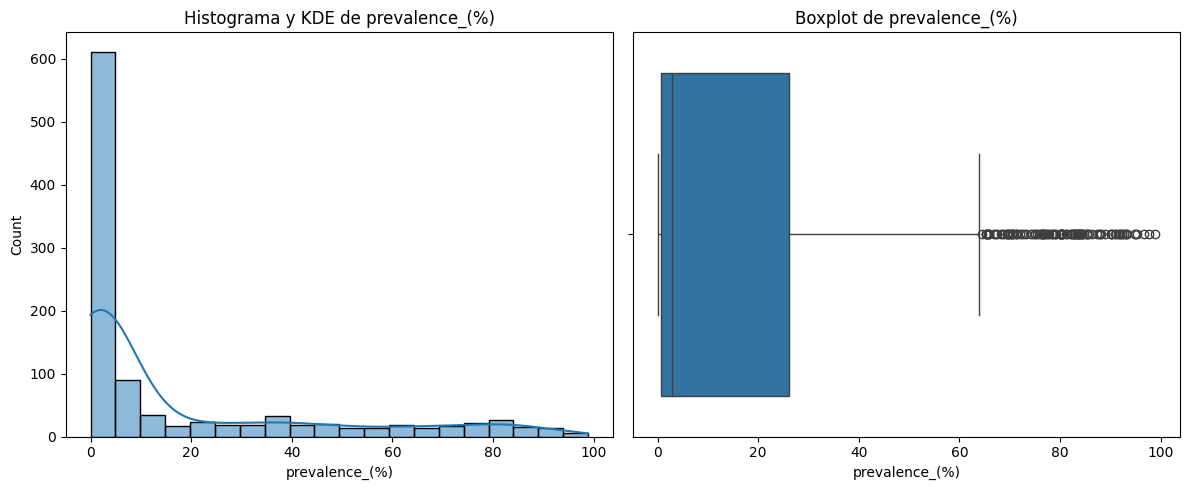

In [139]:
plot_combined_graphs(df_drugs,["prevalence_(%)"])

La mayoría de los registros presenta valores bajos de prevalencia: mediana de 2.8% y media de 17.6%. Esto indicaría la existencia de valores extremos que elevarían el promedio. Estos gráficos, por ende, refuerzan la idea de que hay una concentración de datos en valores bajos, así como de la presencia de outliers extremos. Esto, a su vez, muestra una variabilidad elevada en el consumo en función de la edad y la sustancia.

*Consumo de hombres*

(2,)


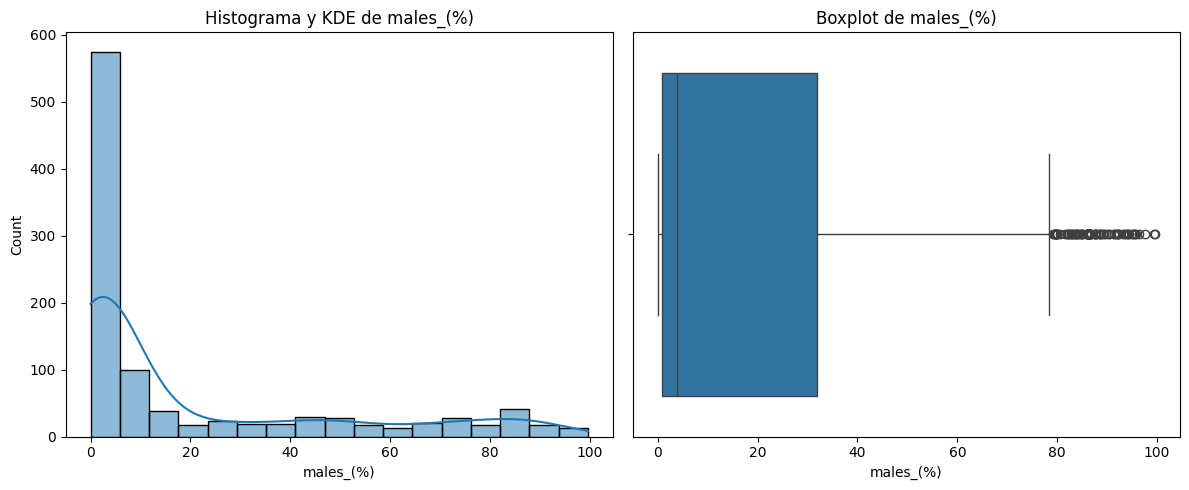

In [140]:
plot_combined_graphs(df_drugs, ["males_(%)"])

Igual que sucedía anteriormente, hay muchos valores bajos, mediana de 3.9% y media de 19.9%. La dispersión y los outliers reflejarían la existencia de casos extremos, los cuales aumentan la variabilidad general del dataset.

*Consumo de mujeres*

(2,)


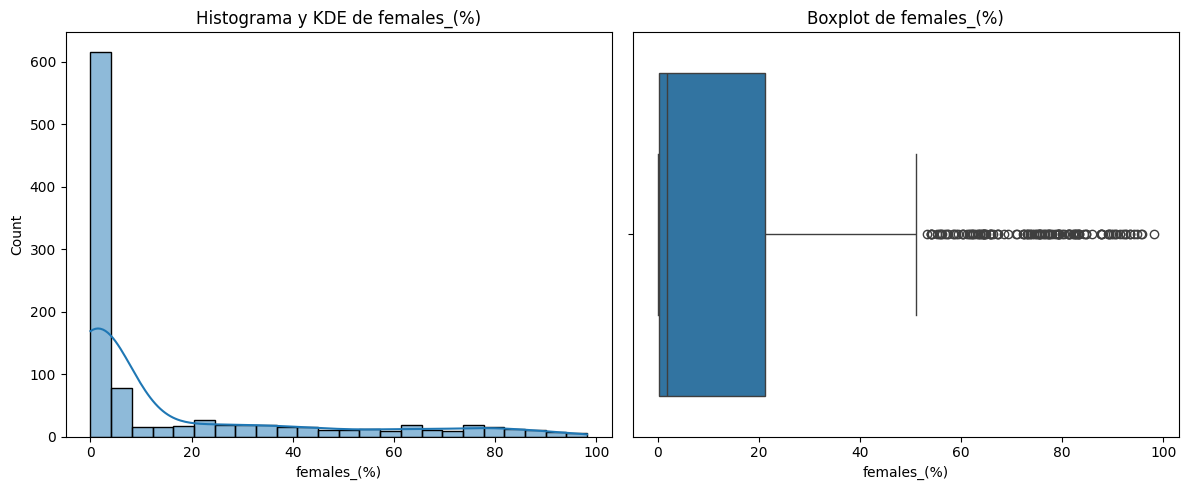

In [141]:
plot_combined_graphs(df_drugs, ["females_(%)"])

Los valores también están concentrados en rangos bajos (mediana de 1.8% y media de 15.6%).
La comparación con la variable de prevalencia total y el consumo masculino muestra que, en general, los hombres consumen más que las mujeres, aunque algunos casos presentan diferencias menores o incluso inversiones.

En términos generales, estos gráficos han mostrado una clara asimetría, dispersión y presencia de outliers en todas las variables de consumo.

Asimismo, se aprecia una relación evidente entre el consumo masculino, femenino y prevalencia total: confirmando que los registros con mayor consumo en hombres suelen tender a elevar la prevalencia general.


**Correlación**

Por otro lado, se han analizado las relaciones entre la prevalencia y el consumo por sexo a través de **coeficientes de correlación de Pearson** y **gráficos de dispersión con líneas de tendencia**.

*Prevalencia y consumo femenino:*

In [138]:
df_drugs[["prevalence_(%)","females_(%)"]].corr()

,prevalence_(%),females_(%)
prevalence_(%),1.000000,0.994642
females_(%),0.994642,1.000000


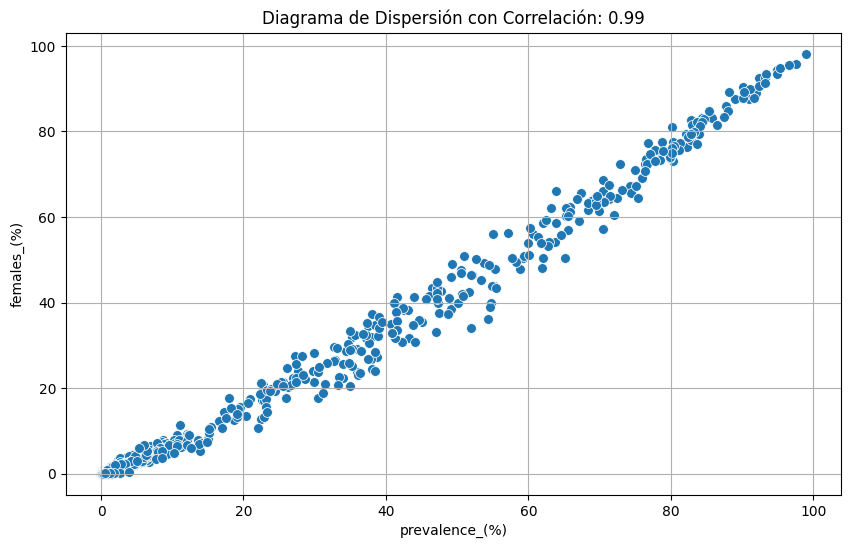

In [142]:
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "females_(%)", mostrar_correlacion=True)

Se ha obtenido una correlación muy elevada (r = 0.995), que muestra una una relación lineal casi perfecta (apreciable también en el gráfico). Esto conlleva que los valores de prevalencia total aumentarían de forma directa a medida que incrementa el consumo femenino.

Por su parte, la gráfica muestra que los puntos se agrupan muy cerca de la línea de tendencia, indicando consistencia entre los datos de mujeres y la prevalencia general.

*Prevalencia y consuo masculino:*

In [137]:
df_drugs[["prevalence_(%)","males_(%)"]].corr()

,prevalence_(%),males_(%)
prevalence_(%),1.000000,0.995688
males_(%),0.995688,1.000000


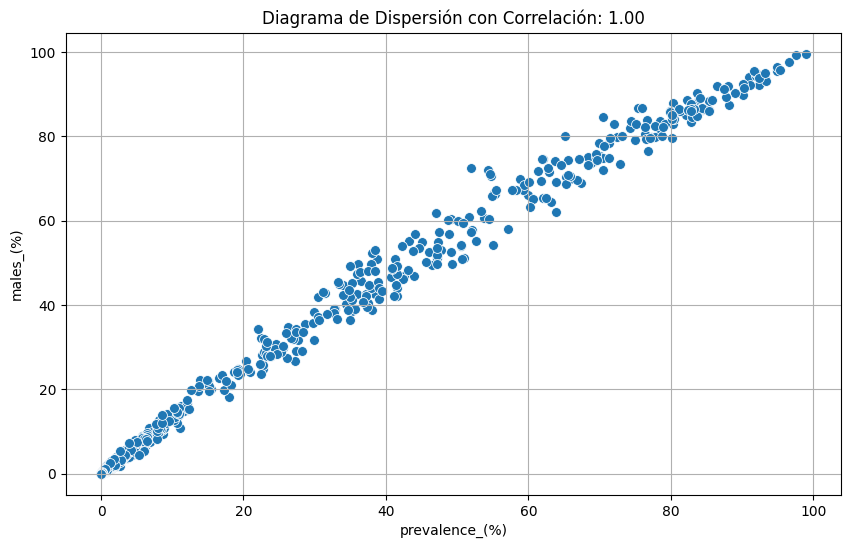

In [143]:
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "males_(%)", mostrar_correlacion=True)

Igual que anteriormente, se tiene una correlación muy elevada (r = 0.996), hecho que muestra que el consumo masculino es un factor determinante en la prevalencia total.
A su vez, el gráfico mostraría también una alineación casi perfecta de los datos a lo largo de la línea.

Los outliers masculinos, por su parte, son más frecuentes que los femeninos y también elevan la prevalencia en ciertos registros: algunos grupos de edad o algunas sustancias tendrían consumos especialmente elevado en hombres. 

*Comparación:*

Tanto hombres como mujeres presentan correlaciones fuertes con la prevalencia del consumo. No obstante, la media del consumo de hombres es suprior a la de las mujeres (19.9% vs 15.6%), hecho que mostraría que el consumo masculino contribuiría a un aumento de la prevlencia general. 

Por su parte, los gráficos de dispersión nos han permitido apreciar dicha diferencia: los puntos de los hombres suelen ocupar valores más altos en el eje, sober todo en los registros extremos.


**Conclusión**

La prevalencia total está fuertemente correlacionada con ambos sexos, lo que confirma que la variación en consumo masculino y femenino explica casi por completo la variabilidad de la prevalencia reportada.

Estos análisis, además de cuantificar la relación, han permitido también visualizar los outliers y la dispersión, enriqueciendo, de esta forma, la interpretación.

Estos resultados reforzarían la Hipótesis 1, mostrando que los hombres tienden a consumir más que las mujeres, aunque ambos sexos tienen un impacto significativo en la prevalencia general.

### ANÁLISIS CATEGÓRICA - NUMÉRICA -- ME HE QUEDADO AQUI, REDACTAR LO QUE HE PUESTO

En el presente apartado se analiza cómo las variables categóricas **edad** y **tipo de sustancia** se relacionan con las variables numéricas **prevalencia del consumo** y **consumo por sexo (males_(%), females_(%)**).

Se han aplicado **ANOVA** y se han generado **gráficos de barras y boxplots** para identificar diferencias significativas entre los grupos, así como visualizar los patrones de consumo.

*Consumo masculino por sustancia*

In [153]:
df_drugs.groupby("substance")["males_(%)"].describe()

,count,mean,std,min,25%,50%,75%,max
substance,,,,,,,,
Alcohol,129.0,78.879845,15.780998,13.8,73.10,83.00,87.80,99.6
Amphetamines,145.0,2.236552,2.797117,0.0,0.40,1.10,2.70,12.0
Cannabis,166.0,16.225904,13.880948,1.0,5.75,11.05,23.85,60.4
Cocaine,155.0,2.928387,3.370301,0.0,0.60,1.60,3.65,17.4
Ecstasy,155.0,2.794839,3.828427,0.0,0.45,1.30,3.70,24.2
LSD,145.0,1.250345,1.665213,0.0,0.10,0.50,1.80,8.7
Tobacco,122.0,49.027049,15.038969,4.5,40.90,48.15,57.60,86.8


En primer lugar y, respecto el consumo masculino por tipo de sustancia, los resultados arrojan diferencias notables respecto dicho consumo por sustancia:

* El alcohol tiene el mayor nivel de consumo en hombres, con una media cercana al 79% y una mediana superior al 83%, indicando un consumo muy extendido

* El tabaco también muestra valores elevados, con una media aproximada del 49% y una dispersión moderada, reflejando una prevalencia elevada, aunque con más variabilidad que el alcohol.

* El cannabis presenta una posición intermedia, con una media de consumo masculino de aproximadamente el 16%, pero con una desviación estándar elevada, hecho que indica una heterogeneidad destacable

* Sustancias como Cocaína, Éxtasis, Anfetaminas y LSD tienen niveles de consumo masculino considerablemente más bajos, con medianas generalmente por debajo del 2%, aunque con ciertos valores extremos que elevan la media.


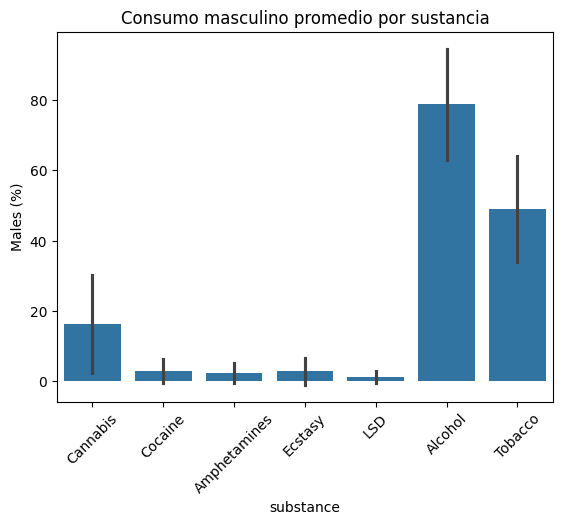

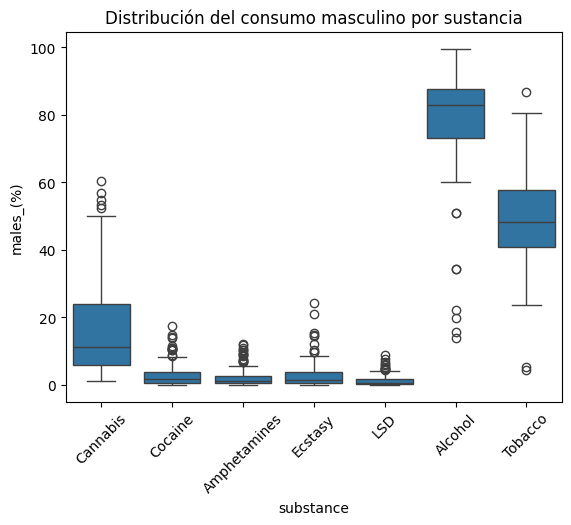

In [167]:
sns.barplot(data=df_drugs, x="substance", y="males_(%)", errorbar='sd')
plt.title("Consumo masculino promedio por sustancia")
plt.ylabel("Males (%)")
plt.xticks(rotation=45)
plt.show()

sns.boxplot(data=df_drugs, x="substance", y="males_(%)")
plt.title("Distribución del consumo masculino por sustancia")
plt.xticks(rotation=45)
plt.show()

La gráfica confirma estos patrones, mostrando distribuciones claramente diferenciadas por sustancia y una mayor dispersión en aquellas con menor consumo medio.

*Consumo femenino por sustancia*

In [154]:
df_drugs.groupby("substance")["females_(%)"].describe()

,count,mean,std,min,25%,50%,75%,max
substance,,,,,,,,
Alcohol,129.0,68.759690,20.472777,3.7,60.300,74.80,82.500,98.2
Amphetamines,143.0,1.090909,1.469066,0.0,0.100,0.50,1.350,7.1
Cannabis,166.0,9.627108,10.679300,0.0,2.125,5.25,13.375,48.8
Cocaine,151.0,1.435099,1.806477,0.0,0.250,0.80,1.750,8.1
Ecstasy,151.0,1.468874,2.288353,0.0,0.200,0.60,1.850,15.4
LSD,139.0,0.533094,0.744194,0.0,0.000,0.20,0.650,4.0
Tobacco,122.0,36.686066,14.695681,6.0,24.850,34.30,46.275,72.4


Respecto el **consumo femenino por tipo de sustancia**, se aprecia que sigue un patrón similar al de los hombres a pesar de que muestra niveles sistemáticamente más bajos:

* El alcohol sigue siendo la sustancia más consumida por las mujeres, con una media cercana al 69% que, aunque es inferior a la masculina, sigue siendo elevada.
* El tabaco presenta una media aproximada del 37%, de nuevo notablemente inferior a la observada en hombres.
* El cannabis tiene una media cercana al 10%, con alta variabilidad
* El consumo femenino de Cocaína, Éxtasis, Anfetaminas y LSD es bajo, con medianas generalmente inferiores al 1%, y menor dispersión que en el consumo masculino.

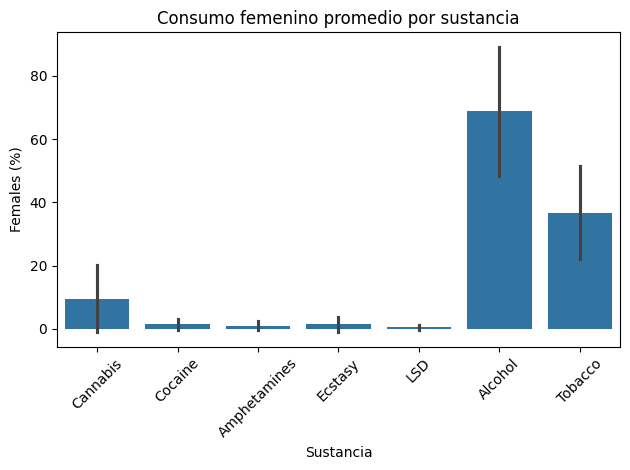

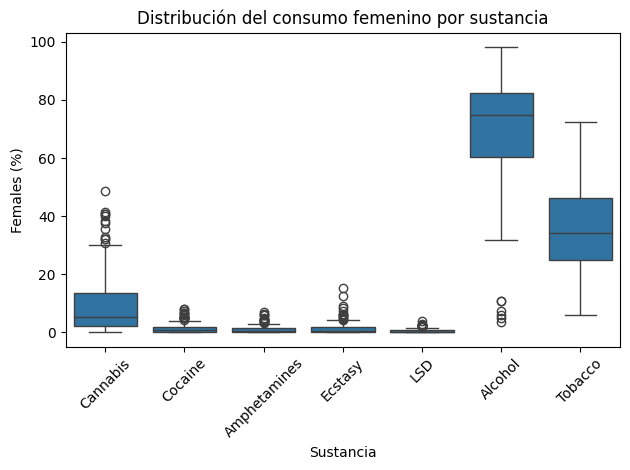

In [170]:
sns.barplot(
    data=df_drugs,
    x="substance",
    y="females_(%)",
    errorbar='sd'  # Desviación estándar como barra de error
)
plt.title("Consumo femenino promedio por sustancia")
plt.ylabel("Females (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

sns.boxplot(
    data=df_drugs,
    x="substance",
    y="females_(%)"
)
plt.title("Distribución del consumo femenino por sustancia")
plt.ylabel("Females (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Las gráficas muestran que, aunque existen casos puntuales de consumo elevado en mujeres, estos son menos frecuentes y menos extremos que en hombres.

Paralelamente, es necesario realizar una comparación entre las mujeres y los hombres:

* Para todas las sustancias que se han analizado, el consumo masculino es superior al femenino
* Las mayores diferencias se observan en el Alcohol, el Tabaco y el Cannabis, que, a su vez, son las que tienen los mayores niveles de consumo en los dos sexos
* En sustancias con baja prevalencia, como el LSD, las diferencias existen pero son menos pronunciadas como consecuencia de los bajos niveles generales de consumo.

En conclusión, este análisis ha mostrado que el consumo es mayor en hombres que en mujeres para todas las sustancias. Además, la elevada dispersión en algunas sustancias sugiere la influencia de factores adicionales como el país, que serán explorados en análisis posteriores.

*Sustancia y prevalencia*

In [155]:
df_drugs.groupby("substance")["prevalence_(%)"].describe()

,count,mean,std,min,25%,50%,75%,max
substance,,,,,,,,
Alcohol,132.0,73.750758,17.686176,8.6,65.825,78.4,84.4,98.9
Amphetamines,149.0,1.663758,2.091366,0.0,0.300,0.7,2.2,9.1
Cannabis,171.0,12.817544,12.108385,0.4,3.950,8.2,19.1,54.5
Cocaine,159.0,2.214465,2.617585,0.0,0.400,1.3,2.8,12.0
Ecstasy,159.0,2.201258,3.130839,0.0,0.400,0.9,2.7,18.6
LSD,148.0,0.925676,1.252922,0.0,0.100,0.4,1.3,6.6
Tobacco,125.0,42.397600,14.321698,5.3,33.400,39.0,51.0,76.3


Por lo que respecta la prevalencia en función al tipo de sustancia, los resultados muestran diferencias notables en la prevalencia en función a la sustancia que se analice:

* El alcohol tiene la mayor prevalencia de consumo con diferencia, con una media aproximada al 74% y una mediana superior al 78%. Esto muestra que se trata de una sustancia cuyo consumo está ampliamente generalizado en la población.
* El tabaco ocupa la segunda posición y tiene una prevalencia media en torno al 42%, hecho que uestra también un consumo elevado pero más heterogéneo que el alcohol.
* El cannabis tiene una prevalencia intermedia (media ≈ 13%), con una desviación estándar elevada, hecho que sugiere diferencias entre  grupos poblacionales.
* Las sustancias como la cocaína, el éxtasis, las anfetaminas y el LSD muestran prevalencias medias muy bajas, por debajo del 3%, lo que indicaría que su consumo es minoritario. No obstante, la presencia de valores máximos relativamente elevados reflejaría la existencia de contextos específicos con consumos superiores significativamente a la media.


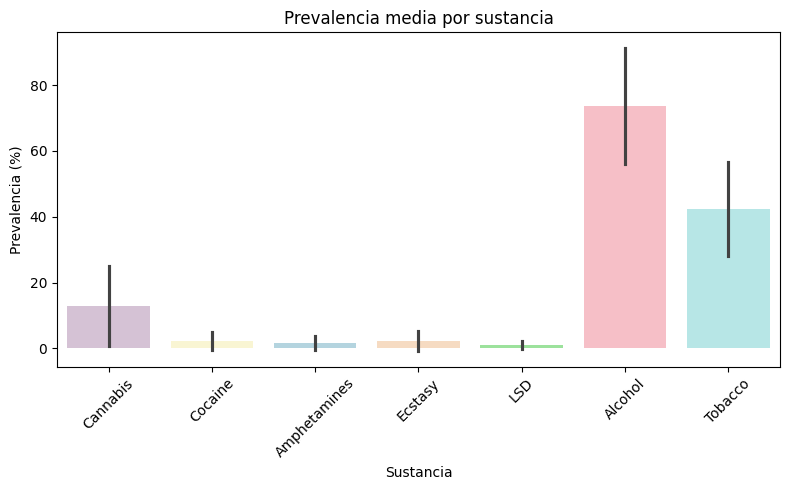

In [177]:
#BARPLOT
plt.figure(figsize=(8,5))

sns.barplot(
    data=df_drugs,
    x="substance",
    y="prevalence_(%)",
    hue="substance",
    errorbar="sd",
    palette=colores_pastel,
    legend=False
)

plt.ylabel("Prevalencia (%)")
plt.xlabel("Sustancia")
plt.title("Prevalencia media por sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

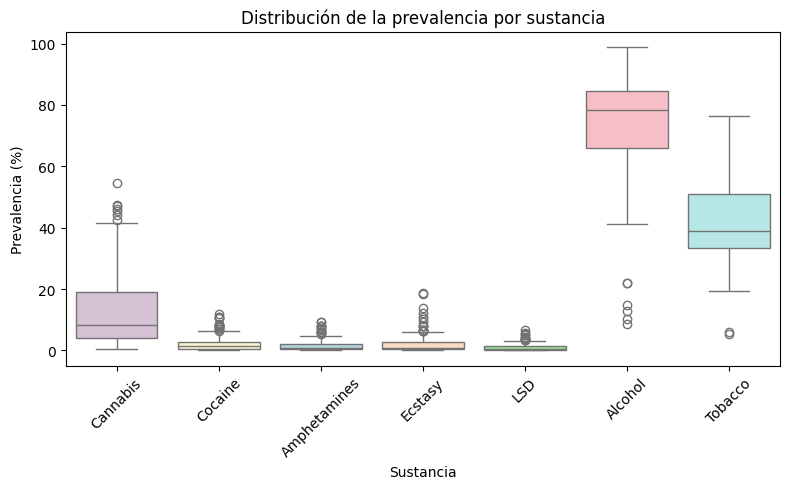

In [178]:
#BOXPLOT
plt.figure(figsize=(8,5))

sns.boxplot(
    data=df_drugs,
    x="substance",
    y="prevalence_(%)",
    hue="substance",
    palette=colores_pastel,
    legend=False
)

plt.ylabel("Prevalencia (%)")
plt.xlabel("Sustancia")
plt.title("Distribución de la prevalencia por sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Las gráficas reforzarían la interpretación anterior, mostrando distribuciones diferenciadas entre sustancias y confirmando la fuerte heterogeneidad del consumo.

*Edad y prevalencia*

In [156]:
df_drugs.groupby("age")["prevalence_(%)"].describe()

,count,mean,std,min,25%,50%,75%,max
age,,,,,,,,
Adults (15-64),528.0,17.150568,27.181936,0.0,0.5,2.2,24.675,97.6
Young adults (15-34),515.0,17.976893,26.338707,0.0,0.8,3.5,27.300,98.9


Respecto la prevalencia del consumo en función al grupo de edad, se observa que los valores medios de prevalencia son similares entre adultos (15–64) y jóvenes adultos (15–34), siendo aproximadamente de 17–18%.

Asimismo, las medianas son ligeramente mayores en el grupo de jóvenes adultos, hecho que sugeriría un consumo más frecuente en este grupo, aunque la diferencia es moderada.

Además, los dos grupos tienen una dispersión elevada y unos valores máximos muy altos, mostrando que la variabilidad del consumo es independiente de la edad.

Por ende, la edad no introduciría diferencias significativas en la prevalencia total del consumo, aunque sí puede influir en el tipo de sustancia o en el consumo por sexo.

A continuación, se muestra una gráfica que complementa el estudio:

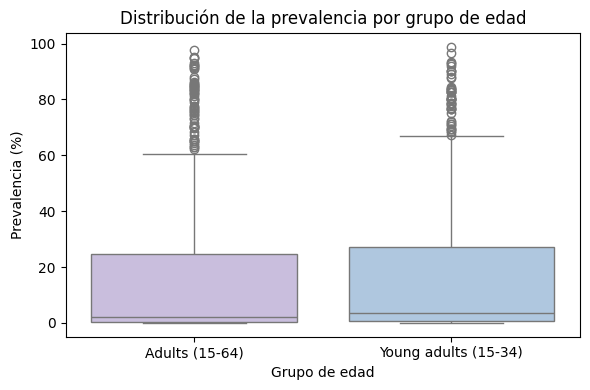

In [180]:
plt.figure(figsize=(6,4))

sns.boxplot(
    data=df_drugs,
    x="age",
    y="prevalence_(%)",
    hue="age",
    palette=["#C7B9E2", "#A7C7E7"],
    legend=False
)

plt.xlabel("Grupo de edad")
plt.ylabel("Prevalencia (%)")
plt.title("Distribución de la prevalencia por grupo de edad")
plt.tight_layout()
plt.show()

**Análisis ANOVA**

*Edad y consumo*

In [182]:
grupos = df_drugs['age'].unique()

prevalencia_por_grupo = [df_drugs[df_drugs['age'] == grupo]['prevalence_(%)'].dropna() for grupo in grupos]

f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 0.248426192331325
Valor p: 0.6182907188674204


Interpretación ANOVA: Edad vs Prevalencia del consumo

Se ha realizado un análisis ANOVA para evaluar si existen diferencias significativas en la prevalencia del consumo (prevalence_(%)) entre los dos grupos de edad: Adults (15–64) y Young adults (15–34):

* El estadístico F obtenido es 0.248, y el p-valor asociado es 0.618
* Comoe el p-valor es mucho mayor que 0.05, no se rechaza la hipótesis nula.

Por ende, no existen diferencias estadísticamente significativas en la prevalencia media del consumo entre adultos y jóvenes adultos, motivo por el cual la edad por sí sola no explicaría las variaciones en el nivel de consumo.

*Edad y consumo de hombres*

In [183]:
grupos = df_drugs['age'].unique()

prevalencia_por_grupo = [df_drugs[df_drugs['age'] == grupo]['males_(%)'].dropna() for grupo in grupos]


f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 0.053066541873767116
Valor p: 0.8178570904383988


En segundo lugar, se ha realizado un ANOVA para evaluar si existen diferencias estadísticamente significativas en el porcentaje de consumo masculino (males_(%)) entre los dos grupos de edad: Adults (15–64) y Young adults (15–34).

* El estadístico F obtenido es 0.053 y el p-valor es 0.818.
* Como que el p-valor es mucho mayor que 0.05, no se rechaza la hipótesis nula.

Por lo tanto, no existen diferencias estadísticamente significativas en el consumo entre hombres adultos y hombres jóvenes adultos, indicando que la edad no afectaría de forma significativa en el consumo de estupefacientes de los hombres.

*Edad y consumo de mujeres*

In [184]:
grupos = df_drugs['age'].unique() 

prevalencia_por_grupo = [df_drugs[df_drugs['age'] == grupo]['females_(%)'].dropna() for grupo in grupos]

f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 0.2142405250399809
Valor p: 0.6435646389013645


En tercer lugar, se ha realizado un ANOVA con el objetivo de evaluar si existen diferencias significativas en el porcentaje de consumo femenino (females_(%)) entre los dos grupos de edad: Adults (15–64) y Young adults (15–34):

* El estadístico F obtenido es 0.214 y el p-valor es 0.644.
* Igual que antes, como el p-valor es superior a 0.05, no se rechaza la hipótesis nula.

Por lo tanto, no existen diferencias estadísticamente significativas en el consumo femenino entre adultos y jóvenes adultos. Por ello e, igual que en hombres, la edad no influiría de forma relevante en el consumo de estupefacientes en mujeres


En términos generales y, en base a los tres ANOVA realizados anteriormente, se confirma que la edad no constituye un factor determinante del nivel de consumo general ni del consumo diferenciado por sexo. Por ello, las diferencias que se puedan observar entre hombres y mujeres no se encontrará condicionada por la edad.


*Sustancia y consumo de hombres*

In [185]:
grupos = df_drugs['substance'].unique()


prevalencia_por_grupo = [df_drugs[df_drugs['substance'] == grupo]['males_(%)'].dropna() for grupo in grupos]


f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 1290.2007844662353
Valor p: 0.0


Por su parte, se ha realizado un ANOVA para evaluar si existen diferencias estadísticamente significativas en el porcentaje de consumo masculino (males_(%)) entre los diversos tipos de sustancia:

* El estadístico F obtenido es 1290.20 y el p-valor es 0.0 (p < 0.001).
* Dado que el p-valor es muy inferior a 0.05, se rechaza la hipótesis nula.

Por ello, existen diferencias significativas en el consumo masculino según la sustancia, confirmando, así, lo observado previamente en el análisis descriptivo:
* Alcohol y tabaco: tienen medias de consumo masculino muy elevadas.
* Cannabis: consumo intermedio.
* Cocaína, Éxtasis, Anfetaminas y LSD: consumos mucho más bajos.

Por ende, el tipo de sustancia tiene un impacto significativo en el consumo masculino: la diferencia en las medias explicaría el valor elevado del estadístico F, informando que el tipo de sustancia constituye un factor determinante en el consumo de los hombres.

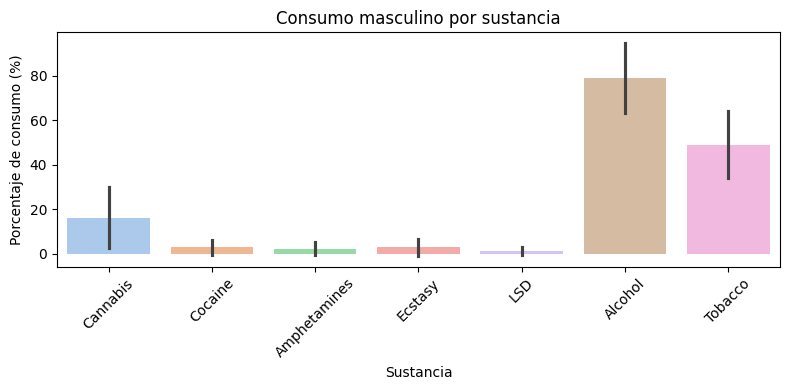

In [196]:
plt.figure(figsize=(8,4))

sns.barplot(
    data=df_drugs,
    x="substance",
    y="males_(%)",
    hue="substance",
    errorbar="sd",
    palette="pastel",
    legend=False
)

plt.title("Consumo masculino por sustancia")
plt.ylabel("Porcentaje de consumo (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La gráfica muestra la prevalencia media del consumo de hombres según el tipo de sustancia, indicando diferencias muy claras entre ellas. El alcohol destaca de forma notable como la sustancia con mayor nivel de consumo masculino, en segundo lugar se sitúa el tabaco, que también presenta valores elevados, aunque por debajo del alcohol.

El cannabis ocupa una posición intermedia, con un consumo masculino apreciable pero menor que el observado en alcohol y tabaco. Por el contrario, las sustancias ilícitas como la cocaína, éxtasis, anfetaminas y LSD tienen niveles de consumo masculino más bajos, con medias muy reducidas en comparación con las sustancias legales.

Así, se pone de manifiesto que el consumo masculino no es homogéneo entre sustancias: está condicionado por el tipo de droga, destacando claramente las sustancias legales frente a las ilegales.

*Sustancia y consumo de mujeres*

In [186]:
grupos = df_drugs['substance'].unique() 


prevalencia_por_grupo = [df_drugs[df_drugs['substance'] == grupo]['females_(%)'].dropna() for grupo in grupos]


f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 903.5849438036058
Valor p: 0.0


Asimismo, se ha realizado un ANOVA para evaluar si existen diferencias estadísticamentee significativas en el porcentaje de consumo femenino (females_(%)) entre los distintos tipos de sustancia:

* El estadístico F obtenido es 903.58 y el p-valor es 0.0 (p < 0.001).
* Como el p-valor es menor que 0.05, se rechaza la hipótesis nula.

Por ello, se puede confirmar que existen diferencias significativas en el consumo femenino según la sustancia. Concretamente, las sustancias con mayor consumo medio entre mujeres son el Alcohol y el Tabaco, seguidas del Cannabis, mientras que la Cocaína, el Éxtasis, las Anfetaminas y el LSD tienen niveles mucho más bajos.

Esto confirmaría los patrones descriptivos observados anteriormente y muestra que, por ende, la sustancia es un factor determinante del nivel de consumo en mujeres.

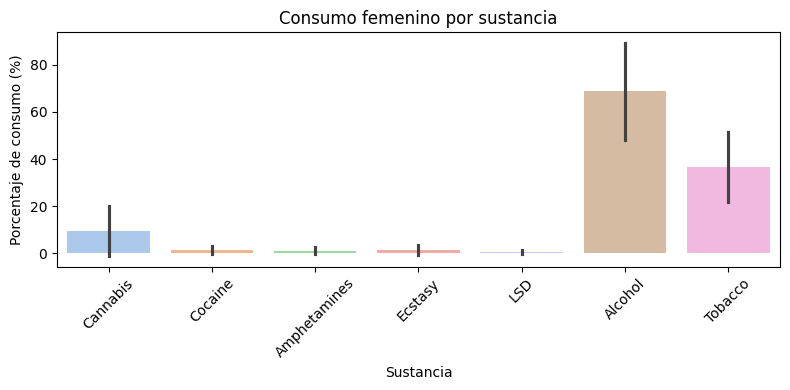

In [197]:
plt.figure(figsize=(8,4))

sns.barplot(
    data=df_drugs,
    x="substance",
    y="females_(%)",
    hue="substance",
    errorbar="sd",
    palette="pastel",
    legend=False
)

plt.title("Consumo femenino por sustancia")
plt.ylabel("Porcentaje de consumo (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La gráfica muestra la prevalencia media del consumo en mujeres según el tipo de sustancia, indicando un patrón claramente diferenciado entre sustancias. Igual que en el consumo masculino, el alcohol es la sustancia con mayor nivel de consumo femenino, seguida del tabaco, aunque en ambos casos con valores medios inferiores a los observados en hombres.

El cannabis tiene un consumo femenino moderado, situándose en una posición intermedia, mientras que las sustancias ilícitas muestran niveles de consumo muy bajos, con medias reducidas y próximas a cero en muchos casos.

Así, la gráfica evidencia que el consumo femenino está fuertemente condicionado por el tipo de sustancia, con una clara predominancia de las sustancias legales y un consumo muy reducido de drogas ilegales.

En términos generales, tanto en mujeres como en hombres, el tipo de sustancia presenta un efecto significativo sobre el porcentaje de consumo.

*Sustancia y prevalencia de consumo*

In [187]:
grupos = df_drugs['substance'].unique() 

prevalencia_por_grupo = [df_drugs[df_drugs['substance'] == grupo]['prevalence_(%)'].dropna() for grupo in grupos]


f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 1185.687259210663
Valor p: 0.0


Por otro lado, se ha analizado un ANOVA con el objetivo de analizar si existen diferencias estadísticamente significativas en la prevalencia del consumo total (prevalence_(%)) entre los distintos tipos de sustancia:

* El estadístico F obtenido es 1185.69 y el p-valor es 0.0 (p < 0.001)
* Como el p-valor es mucho menor que 0.05, se rechaza la hipótesis nula.

Por ende, se confirma que existen diferencias significativas en la prevalencia de consumo según la sustancia: el alcohol y el Tabaco tienen las mayores prevalencias, mientras que el Cannabis presenta un nivel intermedio, y la Cocaína, el Éxtasis, las Anfetaminas y el LSD tienen prevalencias bajas. De esta forma, se aprecia que el tipo de sustancia es clave en la frecuencia de consumo en la población estudiada.

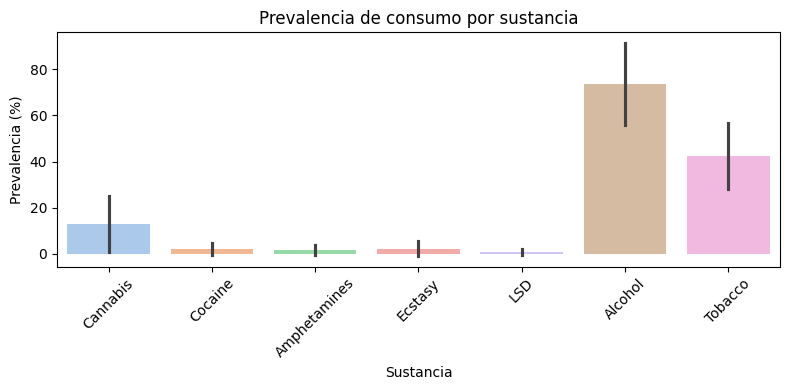

In [199]:
plt.figure(figsize=(8,4))

sns.barplot(
    data=df_drugs,
    x="substance",
    y="prevalence_(%)",
    hue="substance",
    errorbar="sd",
    palette="pastel",
    legend=False
)

plt.title("Prevalencia de consumo por sustancia")
plt.ylabel("Prevalencia (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

La gráfica muestra la prevalencia media total de consumo según el tipo de sustancia, mostrando diferencias marcadas entre ellas. El alcohol destaca claramente como la sustancia con mayor prevalencia de consumo, situándose por encima del resto. En segundo lugar está el tabaco, que también tiene valores elevados, aunque inferiores a los del alcohol.

El cannabis tiene una posición intermedia, con una prevalencia apreciable pero menor que la de las sustancias legales. 

Por el contrario, las drogas ilícitas como cocaína, éxtasis, anfetaminas y LSD muestran niveles de prevalencia muy bajos, con valores medios reducidos en comparación con alcohol, tabaco y cannabis.

En conjunto, la gráfica manifiesta que la prevalencia del consumo está determinada por el tipo de sustancia, con una diferenciación entre sustancias legales y la mayoría de drogas ilegales.

*Consumo por edad, prevalencia y sustancia*

In [188]:
df_age = df_drugs[df_drugs["recall_period"] == "Last year"]

df_age = (
    df_age.sort_values("survey_year")
    .groupby(["substance", "age"])
    .tail(1)
)

grupos_edad = [
    df_age[df_age["age"] == edad]["prevalence_(%)"]
    for edad in df_age["age"].unique()
]

f_val, p_val = stats.f_oneway(*grupos_edad)

print("ANOVA por edad")
print("F:", f_val)
print("p:", p_val)

ANOVA por edad
F: 0.01492350829328512
p: 0.9047928441949864


Por su parte, para analizar si existen diferencias estadísticamente significativas en la prevalencia del consumo durante el último año entre los dos grupos de edad, considerando todas las sustancias, se ha realizado un análisis ANOVA:

* El estadístico F obtenido es 0.015 y el p-valor es 0.905.
* Como el p-valor es mucho mayor que 0.05, no se rechaza la hipótesis nula de igualdad de medias entre grupos.

Por ello, puede establecerse que no existen diferencias significativas en la prevalencia de consumo anual según la edad, indicando que ni la edad ni el tipo de sustancia generan cambios relevantes en el consumo anual entre adultos y jóvenes adultos. Por lo tanto, la edad no constituye un factor determinante del consumo de drogas.

*Sustancias y prevalencia*

In [190]:
grupos_sustancia = [
    df_age[df_age["substance"] == sust]["prevalence_(%)"]
    for sust in df_age["substance"].unique()
]

f_val, p_val = stats.f_oneway(*grupos_sustancia)

print("ANOVA por sustancia")
print("F:", f_val)
print("p:", p_val)

ANOVA por sustancia
F: 300.83851424750475
p: 4.407528212598659e-08


Asimismo, se ha realizado un ANOVA para evaluar si existen diferencias significativas en la prevalencia de consumo entre las distintas sustancias:

* El estadístico F es 300.84 y el p-valor es 4.41×10⁻⁸ (p < 0.001).
* Como el p-valor es mucho menor que 0.05, se rechaza la hipótesis nula.

Así, existen diferencias significativas en la prevalencia del consumo en función a la sustancia. Tal y como se apreció en el análisis descriptivo:

* Alcohol y Tabaco tienen prevalencias muy elevadas.
* Cannabis muestra valores intermedios.
* Cocaína, Éxtasis, Anfetaminas y LSD tienen prevalencias bajas.

Esto indicaría que el tipo de sustancia constituye un factor determinante del consumo, incluso cuando se considera únicamente el último año.

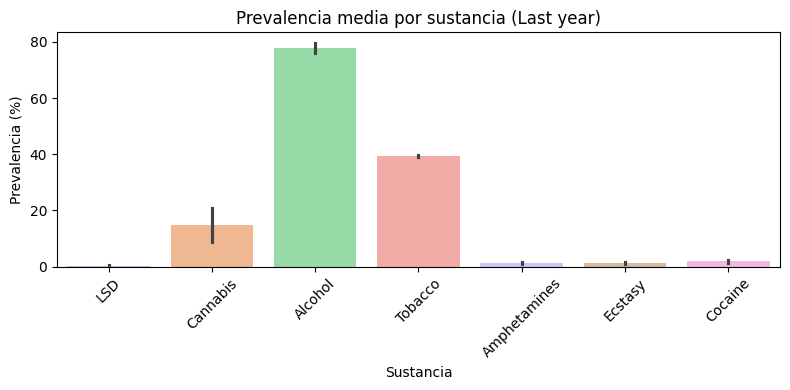

In [191]:
plt.figure(figsize=(8,4))

sns.barplot(
    data=df_age,
    x="substance",
    y="prevalence_(%)",
    errorbar="sd",
    hue="substance",
    palette="pastel",
    legend=False
)

plt.title("Prevalencia media por sustancia (Last year)")
plt.ylabel("Prevalencia (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Tal y como arrojaban los resultados anteriores, en la gráfica puede apreciarse un contraste dedstacable en el consumo de cada sustancia. Se pone de manifiesto, así, que el nivel de consumo no es homogéneo entre sustancias, sino que varía según el tipo de droga. Concretamente, sustancias como alcohol y tabaco presentan prevalencias medias superiores en comparación con otras sustancias como LSD, anfetaminas, cocaína o éxtasis, cuyo consumo es menor.


La magnitud del estadístico F anteriormente mencionado refuerza esta conclusión, sugiriendo que el tipo de sustancia es un factor determinante en la explicación de las diferencias observadas en los niveles de consumo. Este hallazgo es coherente con los resultados descriptivos previos y con la visualización gráfica, donde se aprecian claras diferencias entre sustancias legales y otras drogas de uso menos extendido.


**Conclusión**

El análisis bivariante nos ha permitido analizar cómo las variables edad y tipo de sustancia (categóricas) se relacionan con las variables numéricas prevalencia del consumo y el consumo desagregado por sexo (males_(%), females_(%)).

En primer lugar, al estudiar la variable **edad**, los ANOVA realizados tanto sobre la prevalencia global como sobre el consumo masculino y femenino no mostraron diferencias significativas entre los grupos Adults (15–64) y Young adults (15–34). Los estadísticos F fueron muy bajos y los p-valores muy altos, mostrando, así que la edad no influye significativamente en la frecuencia de consumo ni en la proporción de hombres y mujeres que consumen. Esto se ve reforzado por los gráficos presentados, los cuales muestran medias y medianas similares entre ambos grupos. Así, se puede determinar que la edad no constituye un factor determinante del consumo de drogas en los datos analizados.

En segundo lugar, la variable **sustancia** tiene un efecto significativo sobre todas las medidas de consumo. Los ANOVA informan diferencias  significativas entre sustancias, tanto en la prevalencia global como en los consumos diferenciados por sexo. Los gráficos muestran que el Alcohol y el Tabaco tienen los consumos más elevados, mientras que el Cannabis se sitúa en niveles intermedios y la Cocaína, Éxtasis, Anfetaminas y LSD tienen valores notablemente más bajos. Además, dentro de cada sustancia, los hombres consumen más que las mujeres, confirmando un patrón consistente a lo largo de todas las drogas analizadas. 

En resumen, los resultados del análisis bivariante permiten concluir que:

* La edad no influye significativamente en la prevalencia ni en el consumo por sexo.
* La sustancia es un factor clave que explica la variabilidad en el consumo.
* Los hombres consumen más que las mujeres de manera consistente en todas las sustancias.



## 1.3 ANÁLISIS MULTIVARIANTE - FALTA POR HACER

Para comparar la prevalencia de consumo entre sustancias según la proporción de mujeres, hombres y de la edad

In [ ]:
pivot1 = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="females_(%)",
    columns="substance"
)

In [ ]:
pivot2 = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="males_(%)",
    columns="substance"
)

In [ ]:
pivot3 = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="age",
    columns="substance"
)

Vamos a ver datos descriptivos para resumir  cómo se distribuyen las variables numéricas por grupo de edad:

In [ ]:
cols_num = ["prevalence_(%)", "males_(%)", "females_(%)"]

df_summary = (
    df_drugs_no_na
    .groupby("age")[cols_num]
    .agg(["mean", "median", "std"])
)

df_summary

Para facilitar analisis  posteriores, hacemos analisis descriptivo

In [ ]:
df_drugs_num = df_drugs.select_dtypes(include = ["float","int"])
df_drugs_num.columns

Tabla cruzada para hacer el análisis y comparar simultáneamente:
* Edad (age)
* Tipo de sustancia (substance)
* Género (gender)
* Prevalencia del consumo (prevalence)

In [ ]:
df_gender2 = df_drugs.melt(
    id_vars=["substance", "age"],
    value_vars=["males_(%)", "females_(%)", "prevalence_(%)"],
    var_name="gender",
    value_name="prevalence"
)

df_gender2["gender"] = df_gender2["gender"].str.replace("_(%)", "", regex=False)
df_gender2["prevalence"] = pd.to_numeric(df_gender2["prevalence"], errors="coerce")

df_gender2.head()

pivot_gender2 = df_gender2.pivot_table(
    values="prevalence",
    index="age",
    columns=["substance", "gender"],
    aggfunc="mean"
)

pivot_gender2.head()

Vamos a identificar:
* En qué drogas la diferencia entre hombres y mujeres es mayor
* Qué grupo de edad tiene esa mayor brecha

In [ ]:
topN = 10
rank_gap = (
    df_drugs.dropna(subset=["gender_gap"])
    .sort_values("gender_gap", ascending=False)
    .groupby("substance")
    .head(topN)
)

rank_gap[["substance", "age", "gender_gap"]]

**Comparacion por edad**

In [ ]:
#4 Comparación por edad( Young adults vs Adults)
# 1. Filtrar solo consumo en el último año
df_age = df_drugs[df_drugs["recall_period"] == "Last year"]

# 2. Quedarse con el dato más reciente por sustancia y edad
df_age = (
    df_age.sort_values("survey_year")
    .groupby(["substance", "age"])
    .tail(1)
)

# 3. Tabla de comparación por edad
pivot_age = df_age.pivot_table(
    values="prevalence_(%)",
    index="substance",
    columns="age",
    aggfunc="mean"
)

# 4. Diferencia entre jóvenes y adultos
pivot_age["young_minus_adults"] = (
    pivot_age["Young adults (15-34)"] - pivot_age["Adults (15-64)"]
)

print(pivot_age)

In [ ]:
# 5. Visualización
pivot_age[["Adults (15-64)", "Young adults (15-34)"]].plot(
    kind="bar",
    figsize=(10, 6)
)

plt.ylabel("Prevalencia (%)")
plt.title("Consumo de drogas por grupo de edad (Last year)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**genero**

Identificar relaciones lineales entre variables numéricas,
calcular la matriz de correlación entre todas las variables numéricas del dataframe

In [ ]:
corr_matrix = df_drugs.corr(numeric_only= True)
corr_matrix

In [ ]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
           cbar=True, square=True, linewidths=.5) 


plt.title('Matriz de Correlación')
plt.xticks(rotation=45)
plt.yticks(rotation=45) 


plt.show()


**Genero, edad y sustancia**

In [ ]:
#prevalencia consuno en hombres y mujeres en funcion de droga y la edad
df_mv = df_drugs[df_drugs["recall_period"]=="Last year"].copy()
# Variables dependientes
y_vars = ['males_(%)','females_(%)']

# Fórmula: dependientes ~ factores
formula = 'Q("males_(%)") + Q("females_(%)") ~ C(age) + C(substance) + C(age):C(substance)'

manova = MANOVA.from_formula(formula, data=df_mv)
result = manova.mv_test()
print(result)

**Genero, edad y prevalencia**

In [ ]:
df_mv = df_drugs[df_drugs["recall_period"]=="Last year"].copy()
# Variables dependientes
y_vars = ['males_(%)','females_(%)']

# Fórmula: dependientes ~ factores
formula = 'Q("males_(%)") + Q("females_(%)") ~ C(age) + C(substance) + C(age):C(substance)'

manova = MANOVA.from_formula(formula, data=df_mv)
result = manova.mv_test()
print(result)

In [ ]:
# Variables dependientes
y_vars = ["prevalence"]

# MANOVA: dependiente ~ edad + género + interacción
# Si solo hay 1 variable dependiente, MANOVA se reduce a ANOVA, pero estructura es la misma
formula = 'prevalence ~ C(age) + C(gender) + C(age):C(gender)'

manova = MANOVA.from_formula(formula, data=df_mv_long)
result = manova.mv_test()
print(result)

In [ ]:
# Pivot para heatmap
pivot_heat = df_mv_long.pivot_table(
    values="prevalence",
    index="age",
    columns="gender",
    aggfunc="mean"
)

plt.figure(figsize=(8,5))
sns.heatmap(pivot_heat, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Prevalencia de consumo por edad y género")
plt.show()

análisis multivariante para estudiar si existen diferencias en el consumo de drogas entre hombres y mujeres según la edad y el tipo de sustancia.

MANOVA: evalúa simultáneamente si la prevalencia en hombres (males_(%)) y mujeres (females_(%)) varía según la edad, la sustancia y su interacción.

Brecha de género: calcula la diferencia entre hombres y mujeres (gender_gap) y comprueba estadísticamente si difiere por edad o sustancia mediante ANOVA.

Post-hoc: compara directamente hombres y mujeres dentro de cada combinación de edad y sustancia para identificar en qué grupos la diferencia es más marcada.

Visualización: un gráfico de barras muestra la brecha de género promedio por sustancia y grupo de edad, facilitando la interpretación de los resultados.

In [ ]:
from scipy.stats import f_oneway
# -----------------------------
# 1️⃣ Preparar los datos
# -----------------------------
df_mv = df_drugs[df_drugs["recall_period"]=="Last year"].copy()

# Filtrar filas con valores NaN en males o females
df_mv = df_mv.dropna(subset=["males_(%)","females_(%)"])

# -----------------------------
# 2️⃣ MANOVA
# -----------------------------
# Variables dependientes: males y females
# Factores: age y substance + interacción
formula = 'Q("males_(%)") + Q("females_(%)") ~ C(age) + C(substance) + C(age):C(substance)'

manova = MANOVA.from_formula(formula, data=df_mv)
print("===== RESULTADOS MANOVA =====")
print(manova.mv_test())

# -----------------------------
# 3️⃣ Brecha de género
# -----------------------------
df_mv["gender_gap"] = df_mv["males_(%)"] - df_mv["females_(%)"]

# ANOVA de la brecha según edad y sustancia
# ANOVA por edad
grupos_edad = [df_mv[df_mv["age"]==edad]["gender_gap"] for edad in df_mv["age"].unique()]
f_val, p_val = f_oneway(*grupos_edad)
print("\nANOVA de brecha por edad")
print("F:", f_val)
print("p:", p_val)

# ANOVA por sustancia
grupos_sustancia = [df_mv[df_mv["substance"]==s]["gender_gap"] for s in df_mv["substance"].unique()]
f_val2, p_val2 = f_oneway(*grupos_sustancia)
print("\nANOVA de brecha por sustancia")
print("F:", f_val2)
print("p:", p_val2)

# -----------------------------
# 4️⃣ Post-hoc: diferencias específicas
# -----------------------------
# Comparar brecha dentro de cada sustancia y edad
print("\nPost-hoc: brecha por sustancia y edad")
for sust, age in itertools.product(df_mv["substance"].unique(), df_mv["age"].unique()):
    grupo = df_mv[(df_mv["substance"]==sust) & (df_mv["age"]==age)]
    if grupo.shape[0] > 1:  # necesitamos al menos 2 observaciones
        f_post, p_post = f_oneway(grupo["males_(%)"], grupo["females_(%)"])
        print(f"Sustancia: {sust}, Edad: {age}, F: {f_post:.2f}, p: {p_post:.4f}")


In [ ]:
# -----------------------------
# 5️⃣ Visualización 
# -----------------------------
plt.figure(figsize=(12,6))
sns.barplot(data=df_mv, x="substance", y="gender_gap", hue="age", ci="sd")
plt.title("Brecha de género (hombres - mujeres) por sustancia y edad")
plt.ylabel("Brecha de género (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**gráficas**

In [ ]:
#2.heatmap2: Brecha de género( hombres-mujeres)

pivot_gap2 = df_drugs.pivot_table(
    values="gender_gap",
    index="age",
    columns="substance",
    aggfunc="mean"
)

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_gap2,
    cmap="BrBG",
    center=0,
    annot=True,
    fmt=".1f"
)
plt.title("Brecha de género media por edad y sustancia")
plt.xlabel("Sustancia")
plt.ylabel("Grupo de edad")
plt.tight_layout()
plt.show()

In [ ]:
#Esto es otro heatmap para ver exactamente para los hombres y para las mujeres
plt.figure(figsize=(14,8))
sns.heatmap(pivot_gender2, cmap="YlOrRd", annot=True)
plt.title("Prevalencia por edad, sustancia y género")
plt.ylabel("Edad")
plt.xlabel("Sustancia y género")
plt.show()

## CONCLUSIÓN

# **HIPÓTESIS 2**

*H2. Existen diferencias en la prevalencia del consumo de estupefacientes entre países europeos*

Igual que anteriormente, mostramos el dataframe:

In [45]:
df_drugs

,country,survey_year,prevalence_(%),substance,recall_period,age,sample_size,males_(%),females_(%),gender_gap
0,Austria,2020,22.7,Cannabis,Lifetime,Adults (15-64),4650.0,24.8,20.6,4.2
1,Austria,2020,27.2,Cannabis,Lifetime,Young adults (15-34),1712.0,26.8,27.6,-0.8
2,Austria,2020,6.3,Cannabis,Last year,Adults (15-64),4650.0,6.8,5.8,1.0
3,Austria,2020,11.1,Cannabis,Last year,Young adults (15-34),1712.0,10.7,11.4,-0.7
4,Austria,2020,3.6,Cannabis,Last month,Adults (15-64),4650.0,4.0,3.1,0.9
...,...,...,...,...,...,...,...,...,...,...
1038,Türkiye,2017,47.0,Tobacco,Lifetime,Young adults (15-34),NaN,61.9,33.2,28.7
1039,Türkiye,2017,33.4,Tobacco,Last year,Adults (15-64),NaN,45.0,22.5,22.5
1040,Türkiye,2017,33.2,Tobacco,Last year,Young adults (15-34),NaN,45.4,20.6,24.8
1041,Türkiye,2017,31.5,Tobacco,Last month,Adults (15-64),NaN,42.8,21.0,21.8


## 2.1 ANÁLISIS UNIVARIANTE - HECHO

Para la evaluación de la Hipótesis 2, la variable principal de interés es **country**, puesto que el objetivo es analizar diferencias en la prevalencia de consumo de estupefacientes entre países europeos. Adicionalmente, se han considerado variables como recall_period.

### Variables **Categóricas**

In [202]:
df_drugs.columns = df_drugs.columns.str.lower()

In [203]:
categorical_cols = [
    "country",    
    "substance",
    "recall_period",
    "age"
]

In [207]:
df_drugs["country"].describe()

count        1043
unique         29
top       Austria
freq           42
Name: country, dtype: object

Al analizar los datos descriptivos de **country**, se observa:

* El conjunto de datos contiene 1.043 observaciones.
* Hay 29 países diferentes representados, proporcionando, así una cobertura amplia de Europa.
* El país con mayor frecuencia de observaciones es Austria, con 42 registros, hecho que reflejaría más estudios o encuestas desarrolladas en el país 

In [208]:
df_drugs["recall_period"].describe()

count          1043
unique            3
top       Last year
freq            367
Name: recall_period, dtype: object

Por su parte, la variable **recall_period** muestra:

* Existen 3 categorías distintas: “Last month”, “Last year” y “Lifetime”.
* La categoría más frecuente es “Last year” (367 observaciones) e indica que la mayoría de los registros se refieren al consumo durante el último año.

En términos generales, estos datos permiten contextualizar el análisis, asegurando que las comparaciones entre países se realizan sobre una base adecuada de observaciones y teniendo en cuenta el periodo de referencia del consumo reportado.

Por otro lado, para la evaluación de esta hipótesis, se han estudiado las principales variables categóricas: country, substance, recall_period y age. Esto permitirá entender la composición de los datos y contextualizar la comparación de la prevalencia de consumo entre países.

In [209]:
for col in categorical_cols:
    print(f"\n--- {col}---")
    display(df_drugs[col].value_counts(dropna=False))


--- country---


country
Austria        42
Bulgaria       42
Croatia        42
Cyprus         42
Germany        42
Portugal       42
Romania        42
Italy          42
Slovakia       42
Ireland        42
Latvia         41
Czechia        40
Lithuania      40
Hungary        38
Finland        38
Türkiye        38
Poland         36
Estonia        36
Spain          36
Luxembourg     36
Netherlands    34
Slovenia       34
Greece         32
Denmark        30
France         30
Norway         30
Sweden         22
Belgium        20
Malta          12
Name: count, dtype: int64


--- substance---


substance
Cannabis        171
Cocaine         159
Ecstasy         159
Amphetamines    149
LSD             148
Alcohol         132
Tobacco         125
Name: count, dtype: int64


--- recall_period---


recall_period
Last year     367
Lifetime      348
Last month    328
Name: count, dtype: int64


--- age---


age
Adults (15-64)          528
Young adults (15-34)    515
Name: count, dtype: int64

**1. Países (country)**

El dataset incluye 29 países con un total de 1.043 registros. La mayoría de los estados tienen entre 30 y 42 observaciones, siendo Austria, Bulgaria, Croacia y Chipre, entre otros, los más representados (42 registros cada uno). En el extremo inferior, países como Suecia y Bélgica tienen menos registros, y Malta es el país con menos datos (12 registros).

**2. Sustancias (substance)**

En el estudio se incluyen 7 sustancias diferentes, con el Cannabis como la más frecuente (171 registros), seguido de la Cocaína y el Éxtasis (159 cada uno). Las sustancias con menor representación son el Alcohol (132) y el Tabaco (125), mientras que el LSD y las Anfetaminas tienen conteos intermedios. Esto indica que las encuestas europeas han prestado mayor atención a Cannabis, probablemente porque es la droga más consumida y socialmente relevante en Europa. Las sustancias como LSD, Anfetaminas, Alcohol y Tabaco presentan menos registros, lo que podría reflejar una menor frecuencia de consumo reportada.

**3. Periodo de recuerdo (recall_period)**

El periodo de recuerdo más común es “Last year” (367 registros), seguido de “Lifetime” (348) y “Last month” (328). Esto sugiere que la mayoría de los datos se centran en el consumo reciente (último año), pero también se dispone de información sobre consumo histórico y mensual.

**4. Grupo de edad (age)**

Los registros se dividen prácticamente a partes iguales entre “Adults (15-64)” (528 registros) y “Young adults (15-34)” (515 registros)

A continuación, se muestran las gráficas de cada una de las variables ya comentadas:

*Substance*

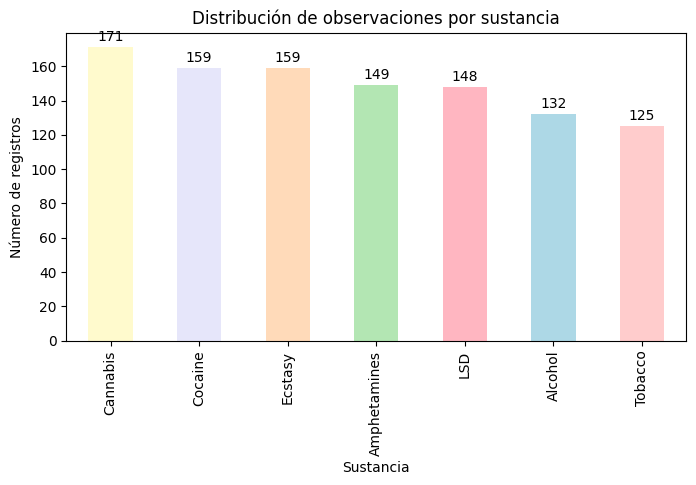

In [211]:
colors = ["#FFFACD", "#E6E6FA", "#FFDAB9", "#B3E6B3", "#FFB6C1", "#ADD8E6", "#FFCCCC"]

counts = df_drugs["substance"].value_counts()

plt.figure(figsize=(8,4))
bars = counts.plot(kind="bar", color=colors)

plt.title("Distribución de observaciones por sustancia")
plt.ylabel("Número de registros")
plt.xlabel("Sustancia")


for i, val in enumerate(counts):
    plt.text(i, val + 2, str(val), ha='center', va='bottom')

plt.show()

*Country*

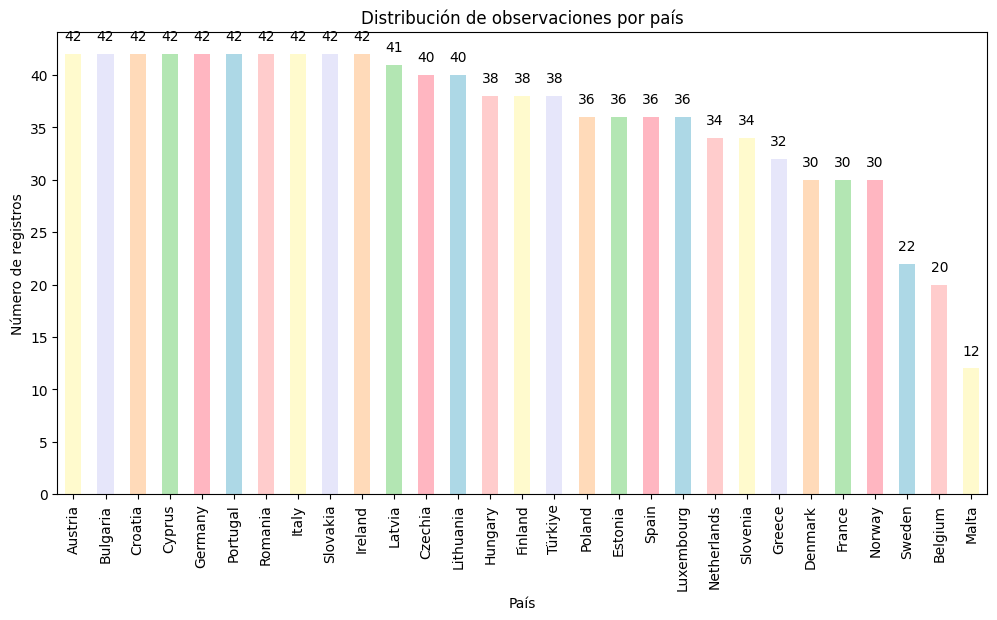

In [218]:
counts = df_drugs["country"].value_counts()
colors = ["#FFFACD", "#E6E6FA", "#FFDAB9", "#B3E6B3", "#FFB6C1", "#ADD8E6", "#FFCCCC"] 

plt.figure(figsize=(12,6))
bars = counts.plot(kind="bar", color=colors * (len(counts)//len(colors)+1)) 

plt.title("Distribución de observaciones por país")
plt.ylabel("Número de registros")
plt.xlabel("País")

for i, val in enumerate(counts):
    plt.text(i, val + 1, str(val), ha='center', va='bottom')

plt.show()

*Recall_period*

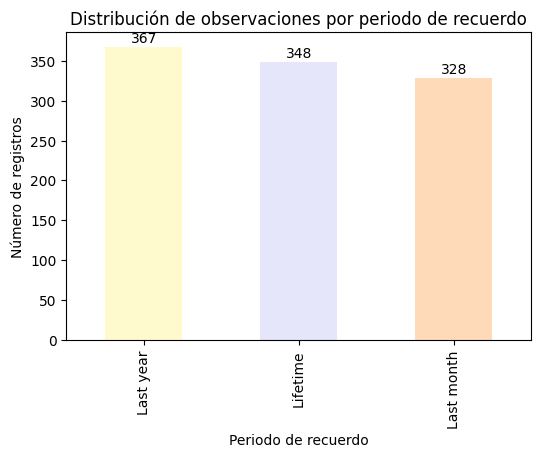

In [216]:
counts = df_drugs["recall_period"].value_counts()

plt.figure(figsize=(6,4))
bars = counts.plot(kind="bar", color=colors[:len(counts)])

plt.title("Distribución de observaciones por periodo de recuerdo")
plt.ylabel("Número de registros")
plt.xlabel("Periodo de recuerdo")

for i, val in enumerate(counts):
    plt.text(i, val + 2, str(val), ha='center', va='bottom')

plt.show()

*Age*

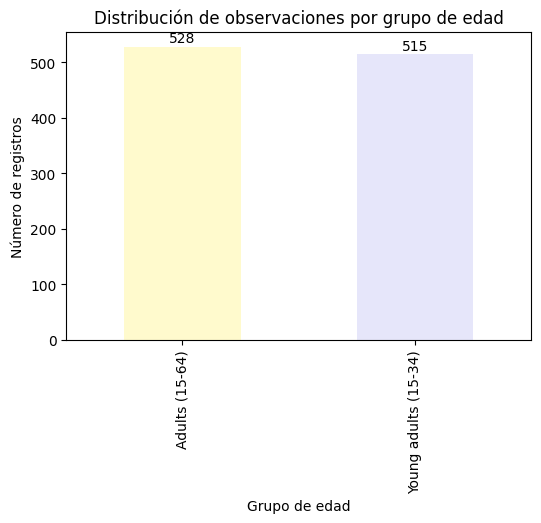

In [217]:
counts = df_drugs["age"].value_counts()

plt.figure(figsize=(6,4))
bars = counts.plot(kind="bar", color=colors[:len(counts)])

plt.title("Distribución de observaciones por grupo de edad")
plt.ylabel("Número de registros")
plt.xlabel("Grupo de edad")

for i, val in enumerate(counts):
    plt.text(i, val + 2, str(val), ha='center', va='bottom')

plt.show()

## 2.2 ANÁLISIS BIVARIANTE - FALTA POR HACER

### CATEGÓRICA - CATEGÓRICA

In [ ]:
df_drugs.groupby("substance")["country"].value_counts(normalize=True)

In [ ]:
plot_categorical_relationship_fin(df_drugs, "country", "substance", relative_freq=True, show_values=False, size_group=5)

In [ ]:
plot_categorical_relationship_fin(df_drugs, "country", "substance", relative_freq=False, show_values=True)

### CATEGORICA - NUMÉRICA

**Mirar para analizar la prevalencia de consumo por edad en los paises (o esto seria multivariante?)**

### Mio (Rebeca) adaptado al análisis

In [ ]:
df_drugs.groupby("country")["females_(%)"].describe()

In [ ]:
plot_categorical_relationship_fin(df_drugs, "females_(%)", "country", relative_freq=True)

In [ ]:
df_drugs.groupby("country")["males_(%)"].describe()

In [ ]:
plot_categorical_relationship_fin(df_drugs, "males_(%)", "country", relative_freq=True)

In [ ]:
df_drugs.groupby("country")["prevalence_(%)"].describe()

In [ ]:
plot_categorical_relationship_fin(df_drugs, "prevalence_(%)", "country", relative_freq=True)

In [ ]:
#  COUNTRY - CONSUMO
grupos2 = df_drugs['country'].dropna().unique()

# Crear la lista de valores de prevalencia por grupo
prevalencia_por_grupo2 = [df_drugs[df_drugs['age'] == grupo]['prevalence_(%)'].dropna() for grupo in grupos]

prevalencia_por_grupo2 = [df_drugs[df_drugs['country'] == grupo]['prevalence_(%)'].dropna()
    for grupo in grupos
    if df_drugs[df_drugs['country'] == grupo]['prevalence_(%)'].dropna().shape[0] > 1
]


# ANOVA
f_val, p_val = stats.f_oneway(*prevalencia_por_grupo2)

print("Valor F:", f_val)
print("Valor p:", p_val)

In [ ]:
#diferencia de consumo por country en funcion de prevalencia y tipo de droga 
df_country = df_drugs[df_drugs["recall_period"] == "Last year"]

df_country = (
    df_country.sort_values("survey_year")
    .groupby(["substance", "country"])
    .tail(1)
)

grupos_country = [
    df_country[df_country["country"] == country]["prevalence_(%)"].dropna()
    for country in df_country["country"].unique()
    if df_country[df_country["country"] == country]["prevalence_(%)"].dropna().shape[0] > 1
]

f_val, p_val = stats.f_oneway(*grupos_country)

print("ANOVA por país")
print("F:", f_val)
print("p:", p_val)

In [ ]:
#anova por sustancia
grupos_country = [
    df_age[df_age["country"] == country]["prevalence_(%)"].dropna()
    for country in df_age["country"].unique()
    if df_age[df_age["country"] == country]["prevalence_(%)"].dropna().shape[0] > 1
]

f_val, p_val = stats.f_oneway(*grupos_country)

print("ANOVA por país")
print("F:", f_val)
print("p:", p_val)

In [ ]:
sns.barplot(
    data=df_age,
    x="substance",
    y="prevalence_(%)",
    hue="age",
    ci="sd"
)

plt.title("Consumo de drogas por edad (Last year)")
plt.ylabel("Prevalencia (%)")
plt.xlabel("Sustancia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2.3 ANÁLISIS MULTIVARIANTE - FALTA POR HACER

In [ ]:
#Cruzamos país+ sustancia+género 

pivot = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="country",
    columns="substance"
)


In [ ]:
# 1) Crear pivot
pivot = df_drugs.pivot_table(
    values="prevalence_(%)",
    index="country",
    columns="substance",
    aggfunc="mean"
)

# 2) Pintar heatmap
plt.figure(figsize=(12,8))
sns.heatmap(pivot)
plt.title("Mapa de calor de prevalencia por país y sustancia")
plt.show()

In [ ]:
df_gender = df_drugs.melt(
    id_vars=["country", "substance", "survey_year", "recall_period", "age"],
    value_vars=["males_(%)", "females_(%)"],
    var_name="gender",
    value_name="prevalence"
)

df_gender["gender"] = df_gender["gender"].str.replace("_(%)", "", regex=False)
df_gender["prevalence"] = pd.to_numeric(df_gender["prevalence"], errors="coerce")

df_gender.head()

pivot_gender = df_gender.pivot_table(
    values="prevalence",
    index="country",
    columns=["substance", "gender"],
    aggfunc="mean"
)

pivot_gender.head()

In [ ]:
#2.heatmap2: Brecha de género( hombres-mujeres)

pivot_gap = df_drugs.pivot_table(
    values="gender_gap",
    index="country",
    columns="substance",
    aggfunc="mean"
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_gap, cmap= "BrBG",
            center=0,)
plt.title("Mapa de calor: brecha de género (Hombres − Mujeres)")
plt.xlabel("Sustancia")
plt.ylabel("País")
plt.tight_layout()
plt.show()

In [ ]:
#3 Países con mayor brecha de género
topN = 10
rank_gap = (
    df_drugs.dropna(subset=["gender_gap"])
    .sort_values("gender_gap", ascending=False)
    .groupby("substance")
    .head(topN)
)

rank_gap[["substance", "country", "survey_year", "gender_gap"]]

In [ ]:
#4 Comparación por edad( Young adults vs Adults)
df_age = df_drugs[df_drugs["recall_period"] == "Last year"]

df_age = (
    df_age.sort_values("survey_year")
    .groupby(["country", "substance", "age"])
    .tail(1)
)

pivot_age = df_age.pivot_table(
    values="prevalence_(%)",
    index="country",
    columns=["age", "substance"],
    aggfunc="mean"
)

## CONCLUSIÓN

# ANOTACIONES

He añadido algunos análisis en el apartado de análisis univariante de la Hipótesis 2 para complementar las gráficas

## COSAS ELIMINADAS DE LA HIPOTESIS 2

### ANALISIS BIVARIANTE

**CATEGÓRICA - CATEGÓRICA**

Elimino las gráficas porque no nos interesa estudiar la relacion de recall period, el de substance-age tampoco porque lo he estudiado en la hipotesis 1. Y country - age tampoco nos aporte  información porque estamos estudiando el consumo por pais, no por año

In [ ]:
plot_categorical_relationship_fin(df_drugs, "country", "recall_period") #eliminar
plot_categorical_relationship_fin(df_drugs, "country", "age") #eliminar
plot_categorical_relationship_fin(df_drugs, "substance", "age", relative_freq=True) #eliminar

**NUMERICA - NUMERICA**

Elimino las gráficas que había porque no tenemos variables numericas para esta hipotesis

In [ ]:
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "survey_year", mostrar_correlacion=True) #eliminarla
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "sample_size", mostrar_correlacion=True) #eliminarla
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "gender_gap", mostrar_correlacion=True) #eliminarla

No nos interesa hacer ninguna correlacion ni grafico entre el año de la encuesta, la grandaria de la muesttra ni gender_gap. Esto no tiene ninguna relacion con nuestra hipotesis de los paises

**CATEGORICA - NUMERICA**

En esta hipotesis no miramos las diferencias por genero, miramos por pais:

In [ ]:
#2.2 Diferencias por género  --> REVISAR PORQUE YO LO ELIMINARIA, NO TIENE SENTIDO EN ESTA HIPOTESIS
#Creamos una variable útil

df_std["gender_gap"] = df_std["males_(%)"] - df_std["females_(%)"]

In [ ]:
#VISUALIZACIÓN

plt.figure(figsize=(6,4))
sns.histplot(df_std["gender_gap"], kde=True)
plt.title("Distribución de la brecha de género (Hombres - Mujeres)")
plt.show()

En esta hipotesis no miramos el consumo por edad, no se esta comparando nada de edad por pais

In [ ]:
#Valores positivos consumen más los hombres ---> REVISAR PORQUE YO LO ELIMINARIA, NO TIENE SENTIDO EN ESTA HIPOTESIS
#Valores negativos más mujeres poco frecuente.
#2.3 Edad
df_age = df_drugs[df_drugs["recall_period"] == "Last year"].copy()

print(df_age.shape)  # para verificar que ya tiene filas

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(data=df_age, x="age", y="prevalence_(%)")
plt.title("Prevalencia (%) por edad (Last year)")
plt.show()

Lo mismo con esta, no está mirando la prevalencia por pais, esta mirando solo la edad y el recall_period

In [94]:
#2.1 Prevalencia por país --> REVISAR PORQUE YO LO ELIMINARIA, HABLA DE EDAD! - PUEDO ADAPTARLO A COUNTRY
#Escenario estándar

df_std = df_drugs[
    (df_drugs["age"] == "Adults (15-64)") &
    (df_drugs["recall_period"] == "Last year")
]
#Todos los países por prevalencia (ej. cannabis)

df_std = df_drugs[
    (df_drugs["age"] == "Adults (15-64)") &
    (df_drugs["recall_period"] == "Last year")
]
